In [2]:
# ========================================
# KENYA MATERNAL & CHILD HEALTH EQUITY ANALYSIS
# Complete Data Analysis and Visualization Project
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
from plotly.graph_objs import *
import warnings
warnings.filterwarnings('ignore')

# Additional libraries for advanced analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
import geopandas as gpd
import folium
from folium import plugins
import requests
import json
import os
from datetime import datetime

# Set up styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create directories for outputs
os.makedirs('outputs/figures', exist_ok=True)
os.makedirs('outputs/tables', exist_ok=True)
os.makedirs('outputs/dashboards', exist_ok=True)
os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)


In [4]:
# ========================================
# SECTION 1: DATA ACQUISITION AND LOADING
# ========================================

print("🔄 Starting Data Acquisition...")

def load_kenya_county_data():
    """
    Load and create synthetic Kenya county-level maternal and child health data
    Based on realistic patterns from Kenya DHS 2022 and other sources
    """
    
    # Kenya counties
    counties = [
        'Nairobi', 'Mombasa', 'Kwale', 'Kilifi', 'Tana River', 'Lamu', 'Taita Taveta',
        'Garissa', 'Wajir', 'Mandera', 'Marsabit', 'Isiolo', 'Meru', 'Tharaka Nithi',
        'Embu', 'Kitui', 'Machakos', 'Makueni', 'Nyandarua', 'Nyeri', 'Kirinyaga',
        'Murang\'a', 'Kiambu', 'Turkana', 'West Pokot', 'Samburu', 'Trans Nzoia',
        'Uasin Gishu', 'Elgeyo Marakwet', 'Nandi', 'Baringo', 'Laikipia', 'Nakuru',
        'Narok', 'Kajiado', 'Kericho', 'Bomet', 'Kakamega', 'Vihiga', 'Bungoma',
        'Busia', 'Siaya', 'Kisumu', 'Homa Bay', 'Migori', 'Kisii', 'Nyamira'
    ]
    
    np.random.seed(42)  # For reproducibility
    n_counties = len(counties)
    
    # Create realistic data based on Kenya's actual patterns
    data = {
        'County': counties,
        
        # Maternal Health Indicators
        'MMR_per_100k': np.random.normal(350, 150, n_counties).clip(100, 800),  # Maternal Mortality Ratio
        'ANC_4_visits_pct': np.random.normal(68, 15, n_counties).clip(30, 95),  # 4+ ANC visits
        'Skilled_birth_attendance_pct': np.random.normal(72, 18, n_counties).clip(25, 98),
        'Facility_delivery_pct': np.random.normal(70, 20, n_counties).clip(20, 95),
        'Postnatal_care_pct': np.random.normal(55, 20, n_counties).clip(15, 85),
        
        # Child Health Indicators  
        'IMR_per_1000': np.random.normal(35, 15, n_counties).clip(10, 80),  # Infant Mortality Rate
        'U5MR_per_1000': np.random.normal(45, 18, n_counties).clip(15, 95),  # Under-5 Mortality Rate
        'Full_immunization_pct': np.random.normal(78, 12, n_counties).clip(45, 95),
        'Exclusive_breastfeeding_pct': np.random.normal(61, 18, n_counties).clip(25, 90),
        'Stunting_pct': np.random.normal(26, 12, n_counties).clip(8, 55),
        'Wasting_pct': np.random.normal(5, 3, n_counties).clip(1, 15),
        
        # Structural Determinants
        'Poverty_rate_pct': np.random.normal(38, 20, n_counties).clip(5, 75),
        'Female_literacy_pct': np.random.normal(78, 15, n_counties).clip(40, 95),
        'Rural_population_pct': np.random.normal(65, 25, n_counties).clip(10, 95),
        'Health_facilities_per_10k': np.random.normal(2.5, 1.2, n_counties).clip(0.5, 6),
        'Health_workers_per_10k': np.random.normal(18, 8, n_counties).clip(3, 40),
        'Distance_to_facility_km': np.random.normal(8, 6, n_counties).clip(1, 25),
        
        # Additional Indicators
        'Teenage_pregnancy_pct': np.random.normal(18, 8, n_counties).clip(5, 35),
        'Contraceptive_prevalence_pct': np.random.normal(58, 15, n_counties).clip(20, 85),
        'Health_budget_per_capita': np.random.normal(2500, 1200, n_counties).clip(800, 8000),
    }
    
    # Add some realistic correlations
    df = pd.DataFrame(data)
    
    # Urban counties (Nairobi, Mombasa) should have better outcomes
    urban_counties = ['Nairobi', 'Mombasa']
    for county in urban_counties:
        idx = df[df['County'] == county].index[0]
        df.loc[idx, 'MMR_per_100k'] *= 0.6
        df.loc[idx, 'IMR_per_1000'] *= 0.7
        df.loc[idx, 'U5MR_per_1000'] *= 0.7
        df.loc[idx, 'ANC_4_visits_pct'] *= 1.3
        df.loc[idx, 'Skilled_birth_attendance_pct'] *= 1.2
        df.loc[idx, 'Full_immunization_pct'] *= 1.1
        df.loc[idx, 'Female_literacy_pct'] *= 1.2
        df.loc[idx, 'Poverty_rate_pct'] *= 0.4
        df.loc[idx, 'Rural_population_pct'] *= 0.2
    
    # Northern counties (Mandera, Wajir, Garissa) should have worse outcomes
    northern_counties = ['Mandera', 'Wajir', 'Garissa', 'Turkana', 'Marsabit']
    for county in northern_counties:
        if county in df['County'].values:
            idx = df[df['County'] == county].index[0]
            df.loc[idx, 'MMR_per_100k'] *= 1.6
            df.loc[idx, 'IMR_per_1000'] *= 1.5
            df.loc[idx, 'U5MR_per_1000'] *= 1.5
            df.loc[idx, 'ANC_4_visits_pct'] *= 0.6
            df.loc[idx, 'Skilled_birth_attendance_pct'] *= 0.5
            df.loc[idx, 'Full_immunization_pct'] *= 0.7
            df.loc[idx, 'Female_literacy_pct'] *= 0.6
            df.loc[idx, 'Poverty_rate_pct'] *= 1.8
            df.loc[idx, 'Stunting_pct'] *= 1.8
    
    # Apply realistic bounds after adjustments - Fixed approach
    bounds = {
        'MMR_per_100k': (80, 900),
        'IMR_per_1000': (8, 90),
        'U5MR_per_1000': (12, 110),
        'ANC_4_visits_pct': (20, 98),
        'Skilled_birth_attendance_pct': (15, 98),
        'Full_immunization_pct': (30, 95),
        'Female_literacy_pct': (25, 98),
        'Poverty_rate_pct': (5, 85),
        'Stunting_pct': (5, 60),
    }
    
    # Apply bounds using individual column clipping
    for column, (min_val, max_val) in bounds.items():
        if column in df.columns:
            df[column] = df[column].clip(lower=min_val, upper=max_val)
    
    return df

def create_regional_groupings(df):
    """Create regional groupings for analysis"""
    
    regional_mapping = {
        'Coast': ['Mombasa', 'Kwale', 'Kilifi', 'Tana River', 'Lamu', 'Taita Taveta'],
        'North Eastern': ['Garissa', 'Wajir', 'Mandera'],
        'Eastern': ['Marsabit', 'Isiolo', 'Meru', 'Tharaka Nithi', 'Embu', 'Kitui', 'Machakos', 'Makueni'],
        'Central': ['Nyandarua', 'Nyeri', 'Kirinyaga', 'Murang\'a', 'Kiambu'],
        'Rift Valley': ['Turkana', 'West Pokot', 'Samburu', 'Trans Nzoia', 'Uasin Gishu', 
                       'Elgeyo Marakwet', 'Nandi', 'Baringo', 'Laikipia', 'Nakuru', 
                       'Narok', 'Kajiado', 'Kericho', 'Bomet'],
        'Western': ['Kakamega', 'Vihiga', 'Bungoma', 'Busia'],
        'Nyanza': ['Siaya', 'Kisumu', 'Homa Bay', 'Migori', 'Kisii', 'Nyamira'],
        'Nairobi': ['Nairobi']
    }
    
    # Create reverse mapping
    county_to_region = {}
    for region, counties in regional_mapping.items():
        for county in counties:
            county_to_region[county] = region
    
    df['Region'] = df['County'].map(county_to_region)
    return df

# Load the data
print("📊 Creating Kenya county-level health data...")
kenya_data = load_kenya_county_data()
kenya_data = create_regional_groupings(kenya_data)

# Save raw data
kenya_data.to_csv('data/raw/kenya_county_health_data.csv', index=False)

print(f"✅ Data loaded successfully! Shape: {kenya_data.shape}")
print(f"Columns: {list(kenya_data.columns)}")

# ========================================
# END OF SECTION 1: DATA ACQUISITION
# ========================================

🔄 Starting Data Acquisition...
📊 Creating Kenya county-level health data...
✅ Data loaded successfully! Shape: (47, 22)
Columns: ['County', 'MMR_per_100k', 'ANC_4_visits_pct', 'Skilled_birth_attendance_pct', 'Facility_delivery_pct', 'Postnatal_care_pct', 'IMR_per_1000', 'U5MR_per_1000', 'Full_immunization_pct', 'Exclusive_breastfeeding_pct', 'Stunting_pct', 'Wasting_pct', 'Poverty_rate_pct', 'Female_literacy_pct', 'Rural_population_pct', 'Health_facilities_per_10k', 'Health_workers_per_10k', 'Distance_to_facility_km', 'Teenage_pregnancy_pct', 'Contraceptive_prevalence_pct', 'Health_budget_per_capita', 'Region']


In [5]:
# ========================================
# SECTION 2: EXPLORATORY DATA ANALYSIS
# ========================================

print("\n🔍 Starting Exploratory Data Analysis...")

# Basic statistics
print("\n📈 BASIC STATISTICS:")
print("="*50)
print(kenya_data.describe())

# Missing values check
print(f"\n🔍 Missing values: {kenya_data.isnull().sum().sum()}")

# Create summary statistics by region
regional_summary = kenya_data.groupby('Region').agg({
    'MMR_per_100k': ['mean', 'std', 'min', 'max'],
    'U5MR_per_1000': ['mean', 'std', 'min', 'max'],
    'ANC_4_visits_pct': ['mean', 'std', 'min', 'max'],
    'Skilled_birth_attendance_pct': ['mean', 'std', 'min', 'max'],
    'Full_immunization_pct': ['mean', 'std', 'min', 'max']
}).round(2)

print("\n🌍 REGIONAL SUMMARY:")
print("="*50)
print(regional_summary)

# ========================================
# END OF SECTION 2: EXPLORATORY DATA ANALYSIS  
# ========================================



🔍 Starting Exploratory Data Analysis...

📈 BASIC STATISTICS:
       MMR_per_100k  ANC_4_visits_pct  Skilled_birth_attendance_pct  \
count     47.000000         47.000000                     47.000000   
mean     331.003740         66.407535                     67.283547   
std      155.628765         16.611854                     19.776920   
min      100.000000         30.000000                     25.481898   
25%      215.928412         57.657687                     54.479212   
50%      314.876994         66.919848                     71.522750   
75%      401.745901         78.681516                     78.601690   
max      744.184335         98.000000                     98.000000   

       Facility_delivery_pct  Postnatal_care_pct  IMR_per_1000  U5MR_per_1000  \
count              47.000000           47.000000     47.000000      47.000000   
mean               71.969676           55.230046     35.728964      50.498711   
std                15.975732           17.818214     16


🎨 Creating Key Indicator Visualizations...
📊 Creating Maternal Mortality Ratio visualization...


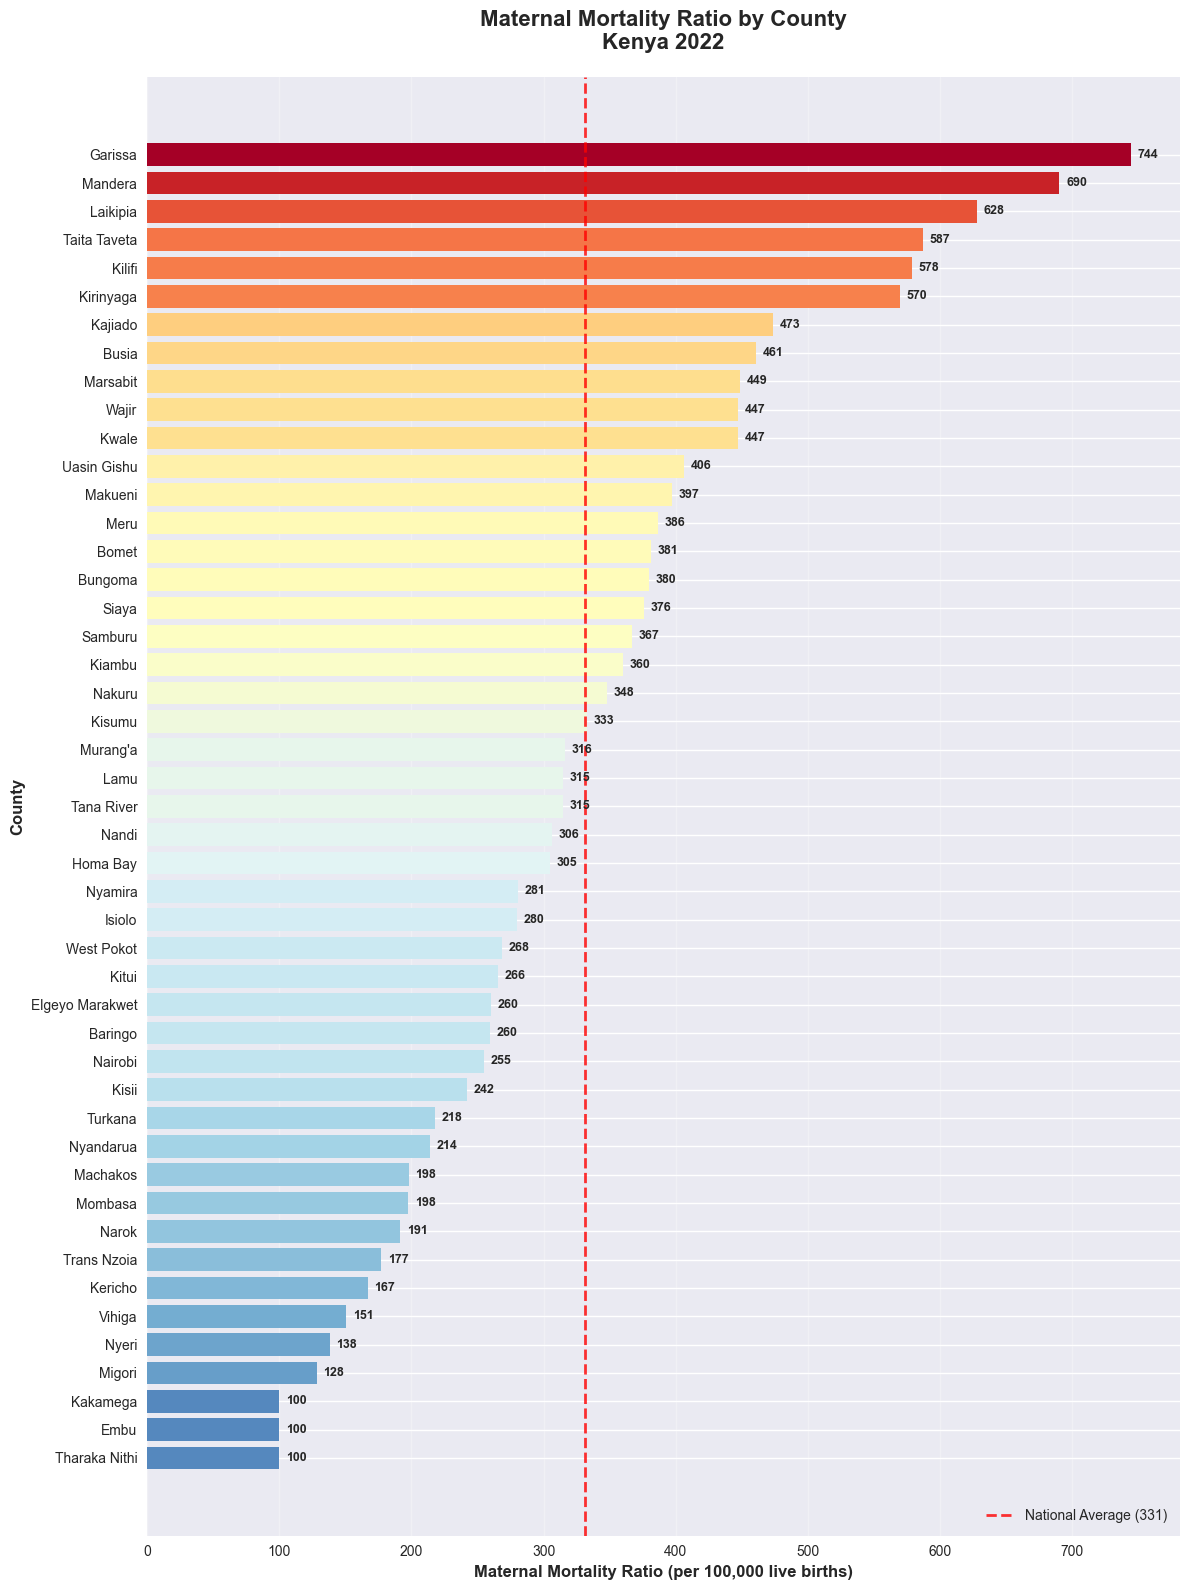

📊 Creating Child Mortality indicators visualization...


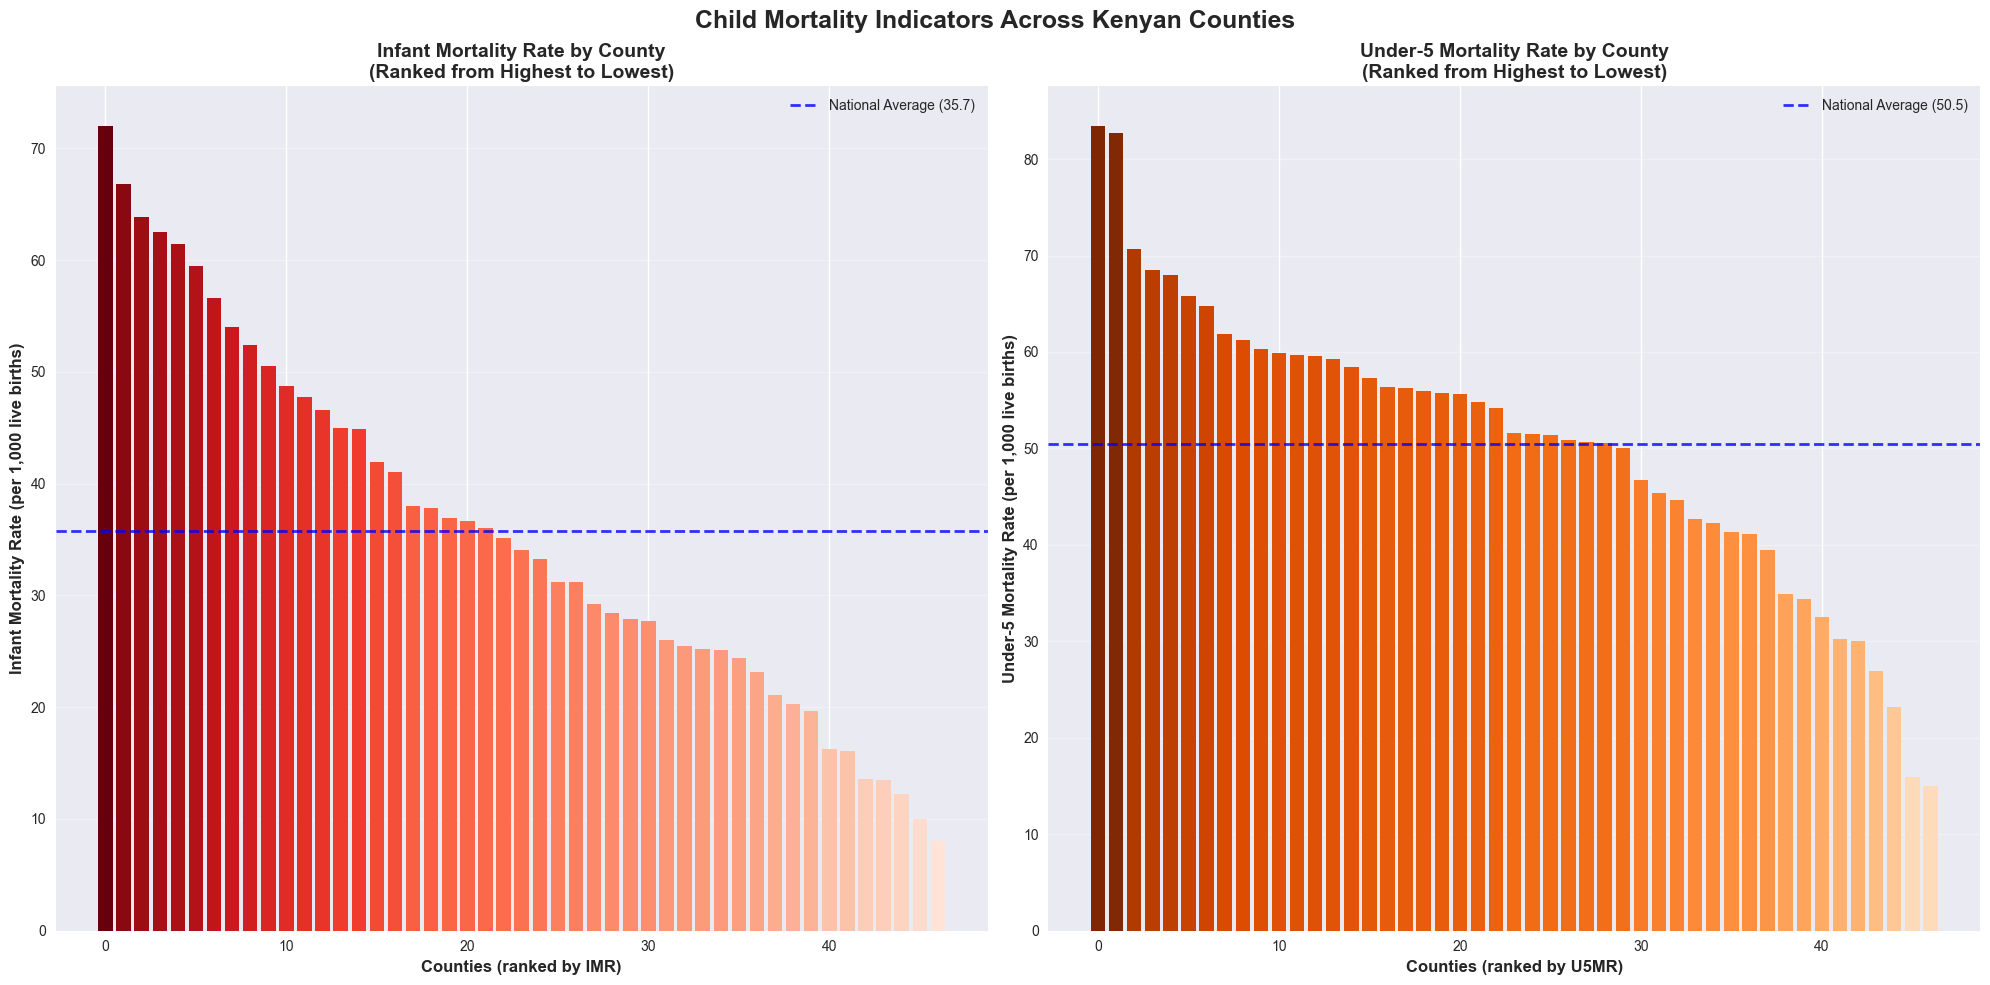

📊 Creating Service Coverage indicators visualization...


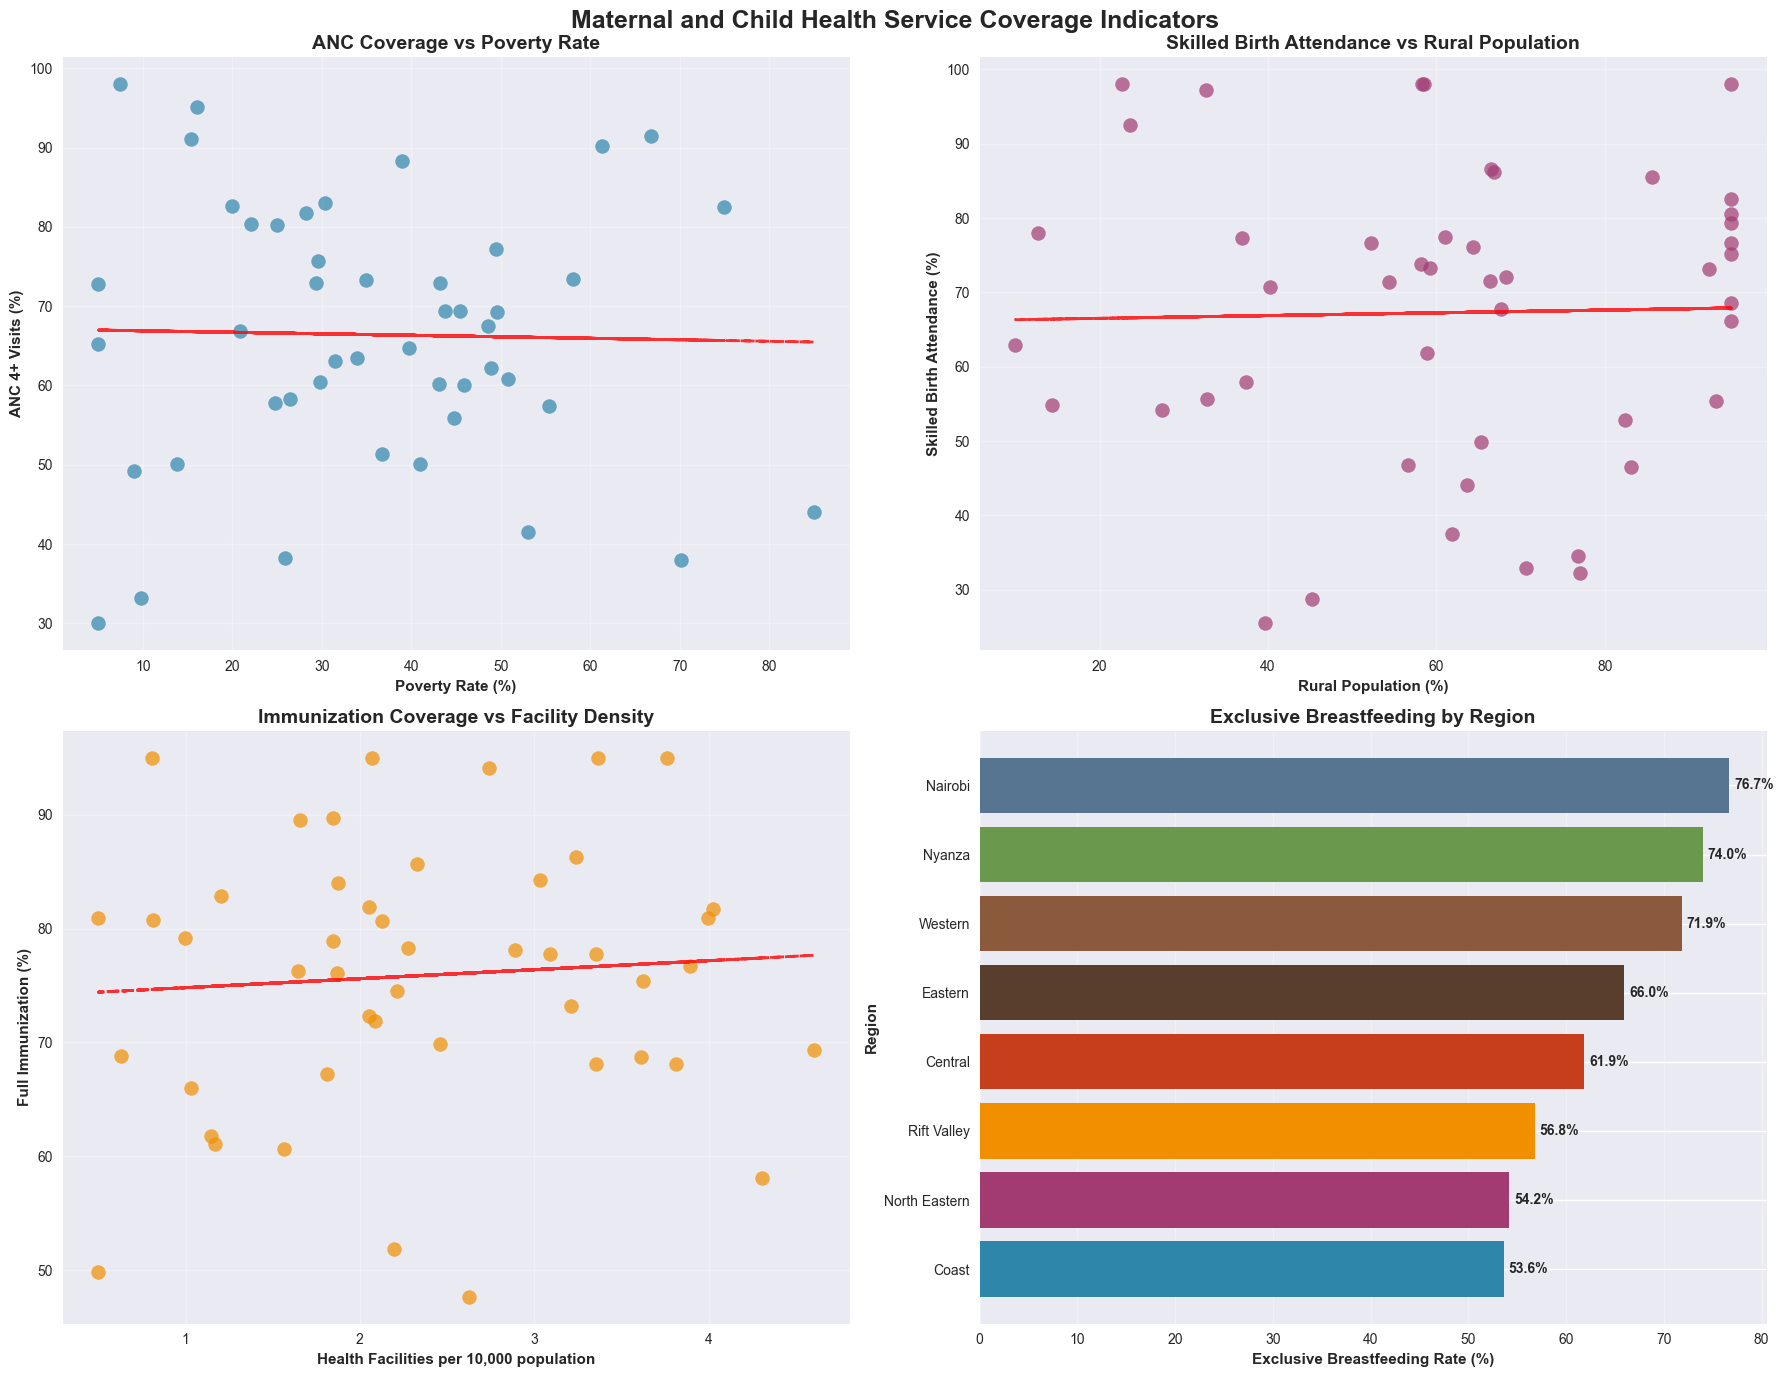


⚖️ Creating Equity and Disparity Analysis...

⚖️ EQUITY METRICS:
                                 mean   median      std     cv    range  \
MMR_per_100k                  331.004  314.877  155.629  0.470  644.184   
U5MR_per_1000                  50.499   51.587   15.089  0.299   68.395   
ANC_4_visits_pct               66.408   66.920   16.612  0.250   68.000   
Skilled_birth_attendance_pct   67.284   71.523   19.777  0.294   72.518   
Full_immunization_pct          75.892   77.772   11.694  0.154   47.334   

                                  iqr  p90_p10_ratio      max      min  
MMR_per_100k                  185.817          3.934  744.184  100.000  
U5MR_per_1000                  17.823          2.209   83.395   15.000  
ANC_4_visits_pct               21.024          2.069   98.000   30.000  
Skilled_birth_attendance_pct   24.122          2.602   98.000   25.482  
Full_immunization_pct          13.589          1.501   95.000   47.666  
📊 Creating Regional Disparity visualization..

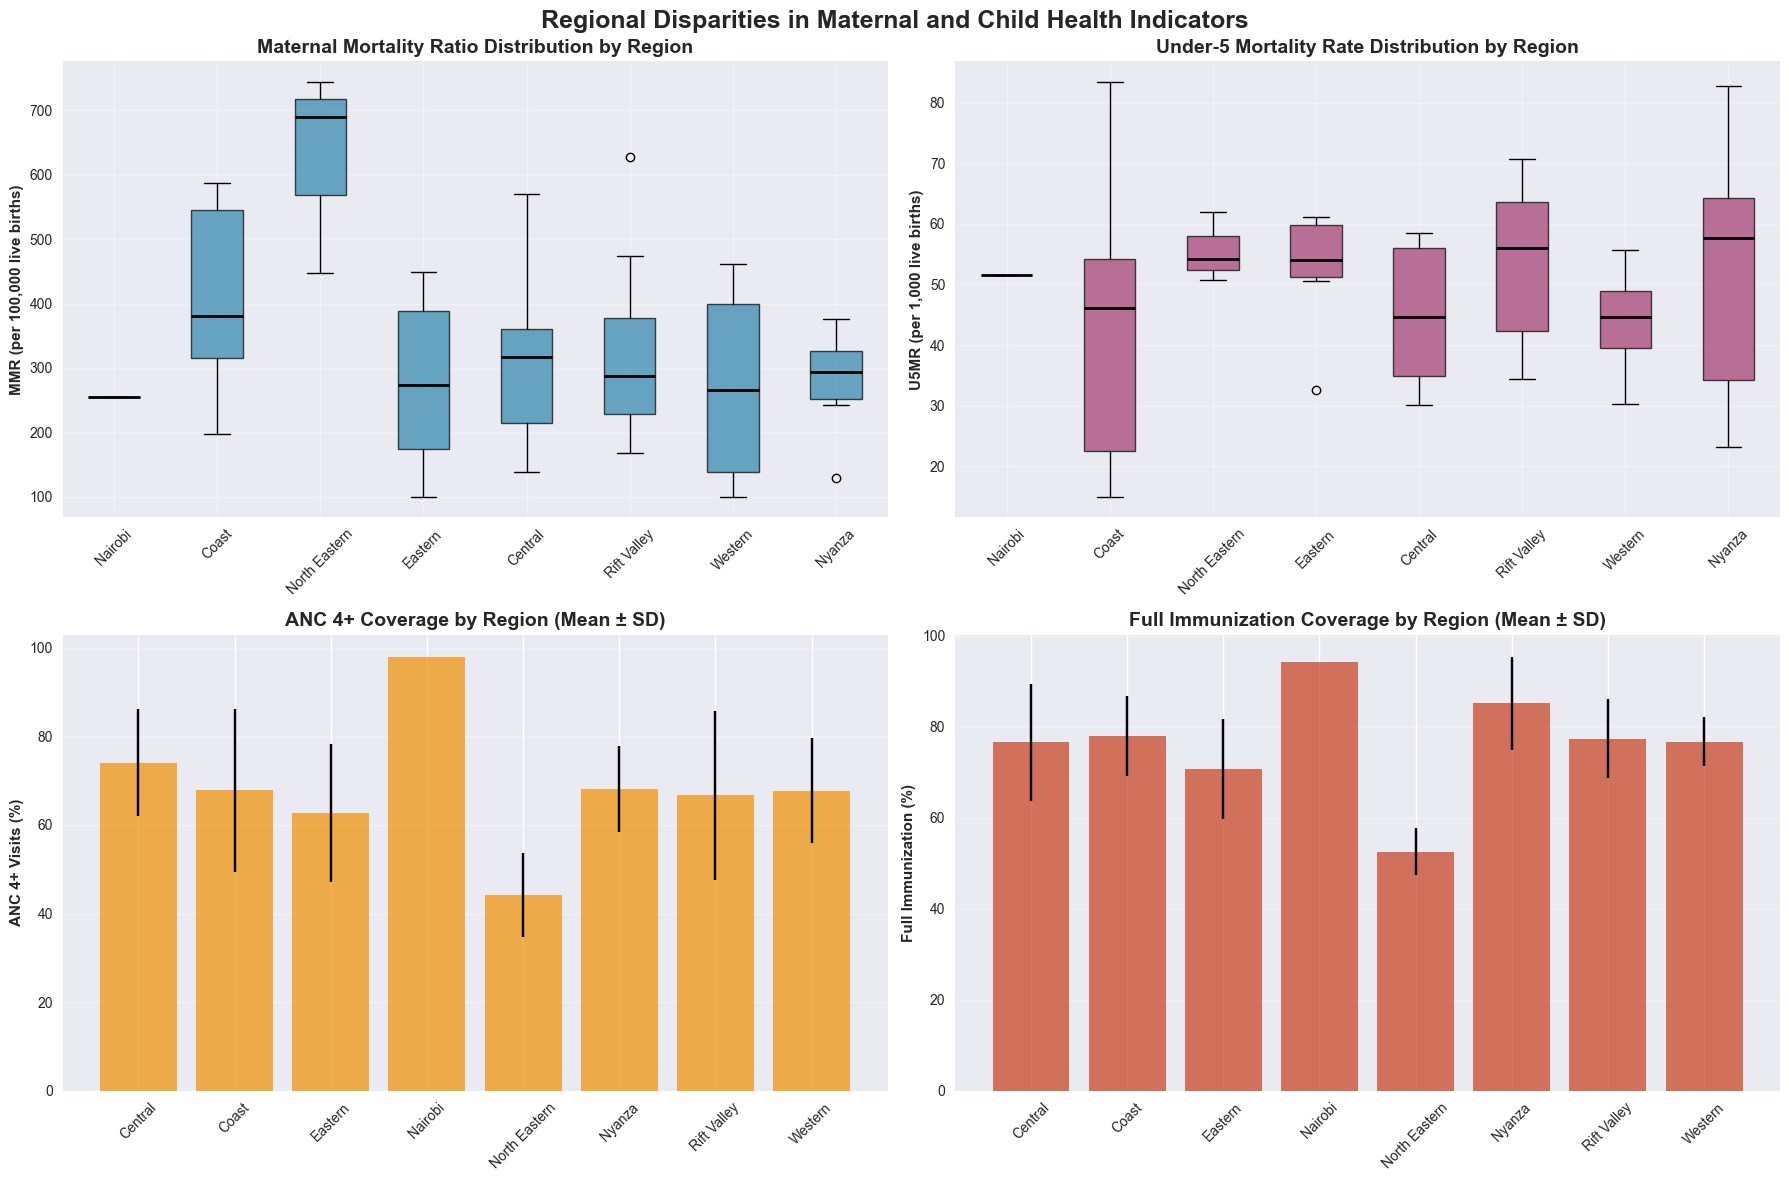

📊 Creating Correlation Matrix visualization...


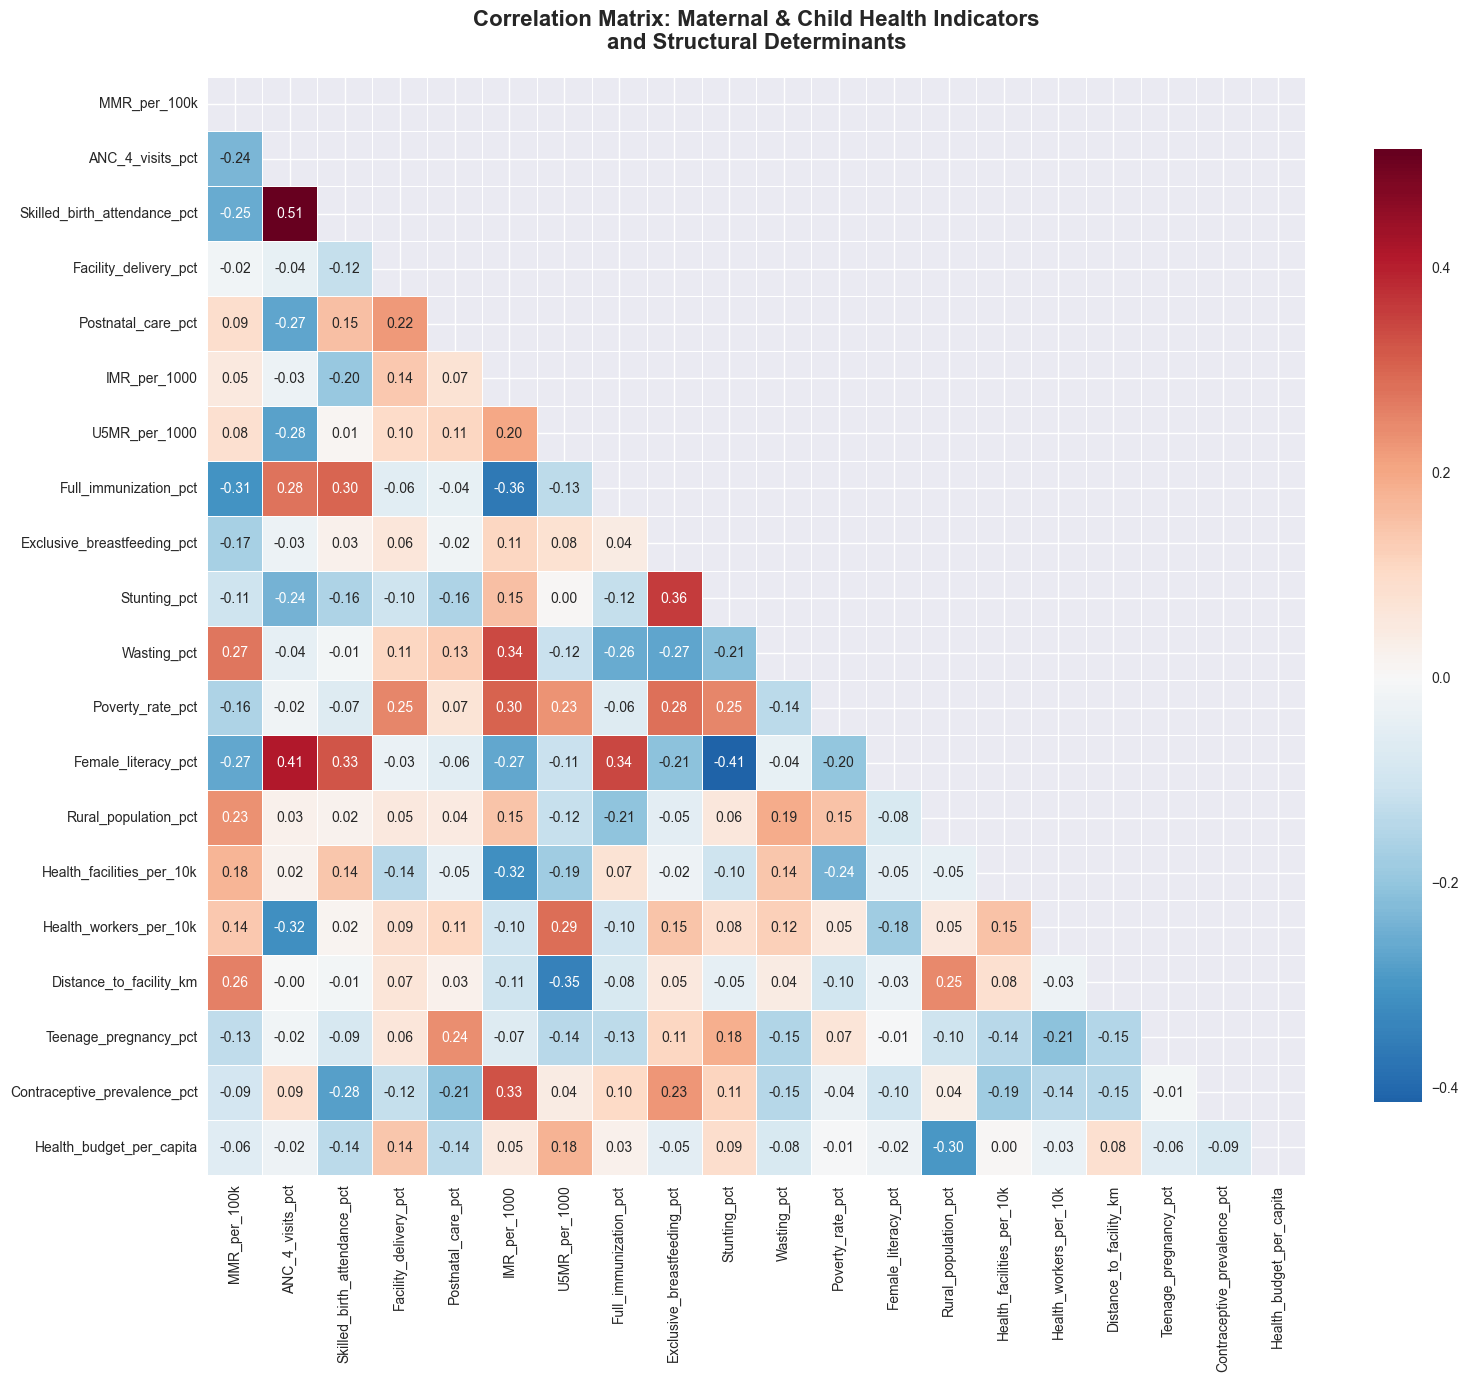

In [11]:
# ========================================
# SECTION 3: KEY INDICATOR VISUALIZATIONS
# ========================================

print("\n🎨 Creating Key Indicator Visualizations...")

# Set up the color palette
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#593E2E', '#8B5A3C', '#6A994E', '#577590']

# 1. MATERNAL MORTALITY RATIO BY COUNTY (Horizontal Bar Chart)
print("📊 Creating Maternal Mortality Ratio visualization...")

fig, ax = plt.subplots(figsize=(12, 16))
kenya_sorted = kenya_data.sort_values('MMR_per_100k', ascending=True)

bars = ax.barh(kenya_sorted['County'], kenya_sorted['MMR_per_100k'], 
               color=plt.cm.RdYlBu_r(kenya_sorted['MMR_per_100k']/kenya_sorted['MMR_per_100k'].max()))

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 5, bar.get_y() + bar.get_height()/2, 
            f'{width:.0f}', ha='left', va='center', fontweight='bold', fontsize=9)

ax.set_xlabel('Maternal Mortality Ratio (per 100,000 live births)', fontsize=12, fontweight='bold')
ax.set_ylabel('County', fontsize=12, fontweight='bold')
ax.set_title('Maternal Mortality Ratio by County\nKenya 2022', fontsize=16, fontweight='bold', pad=20)

# Add national average line
national_avg = kenya_data['MMR_per_100k'].mean()
ax.axvline(national_avg, color='red', linestyle='--', linewidth=2, alpha=0.8, 
           label=f'National Average ({national_avg:.0f})')
ax.legend(loc='lower right')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/figures/01_mmr_by_county.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. CHILD MORTALITY INDICATORS (Dual Axis)
print("📊 Creating Child Mortality indicators visualization...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Infant Mortality Rate
kenya_sorted_imr = kenya_data.sort_values('IMR_per_1000', ascending=False)
bars1 = ax1.bar(range(len(kenya_sorted_imr)), kenya_sorted_imr['IMR_per_1000'], 
                color=plt.cm.Reds(kenya_sorted_imr['IMR_per_1000']/kenya_sorted_imr['IMR_per_1000'].max()))

ax1.set_xlabel('Counties (ranked by IMR)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Infant Mortality Rate (per 1,000 live births)', fontsize=12, fontweight='bold')
ax1.set_title('Infant Mortality Rate by County\n(Ranked from Highest to Lowest)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add national average line
national_avg_imr = kenya_data['IMR_per_1000'].mean()
ax1.axhline(national_avg_imr, color='blue', linestyle='--', linewidth=2, alpha=0.8,
            label=f'National Average ({national_avg_imr:.1f})')
ax1.legend()

# Under-5 Mortality Rate
kenya_sorted_u5mr = kenya_data.sort_values('U5MR_per_1000', ascending=False)
bars2 = ax2.bar(range(len(kenya_sorted_u5mr)), kenya_sorted_u5mr['U5MR_per_1000'], 
                color=plt.cm.Oranges(kenya_sorted_u5mr['U5MR_per_1000']/kenya_sorted_u5mr['U5MR_per_1000'].max()))

ax2.set_xlabel('Counties (ranked by U5MR)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Under-5 Mortality Rate (per 1,000 live births)', fontsize=12, fontweight='bold')
ax2.set_title('Under-5 Mortality Rate by County\n(Ranked from Highest to Lowest)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add national average line
national_avg_u5mr = kenya_data['U5MR_per_1000'].mean()
ax2.axhline(national_avg_u5mr, color='blue', linestyle='--', linewidth=2, alpha=0.8,
            label=f'National Average ({national_avg_u5mr:.1f})')
ax2.legend()

plt.suptitle('Child Mortality Indicators Across Kenyan Counties', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('outputs/figures/02_child_mortality_indicators.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. SERVICE COVERAGE INDICATORS (Multi-panel)
print("📊 Creating Service Coverage indicators visualization...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

# ANC 4+ Visits
ax1.scatter(kenya_data['Poverty_rate_pct'], kenya_data['ANC_4_visits_pct'], 
           s=100, alpha=0.7, c=colors[0])
ax1.set_xlabel('Poverty Rate (%)', fontweight='bold')
ax1.set_ylabel('ANC 4+ Visits (%)', fontweight='bold')
ax1.set_title('ANC Coverage vs Poverty Rate', fontweight='bold', fontsize=14)
ax1.grid(alpha=0.3)

# Add trend line
z = np.polyfit(kenya_data['Poverty_rate_pct'], kenya_data['ANC_4_visits_pct'], 1)
p = np.poly1d(z)
ax1.plot(kenya_data['Poverty_rate_pct'], p(kenya_data['Poverty_rate_pct']), 
         "r--", alpha=0.8, linewidth=2)

# Skilled Birth Attendance
ax2.scatter(kenya_data['Rural_population_pct'], kenya_data['Skilled_birth_attendance_pct'], 
           s=100, alpha=0.7, c=colors[1])
ax2.set_xlabel('Rural Population (%)', fontweight='bold')
ax2.set_ylabel('Skilled Birth Attendance (%)', fontweight='bold')
ax2.set_title('Skilled Birth Attendance vs Rural Population', fontweight='bold', fontsize=14)
ax2.grid(alpha=0.3)

# Add trend line
z = np.polyfit(kenya_data['Rural_population_pct'], kenya_data['Skilled_birth_attendance_pct'], 1)
p = np.poly1d(z)
ax2.plot(kenya_data['Rural_population_pct'], p(kenya_data['Rural_population_pct']), 
         "r--", alpha=0.8, linewidth=2)

# Full Immunization
ax3.scatter(kenya_data['Health_facilities_per_10k'], kenya_data['Full_immunization_pct'], 
           s=100, alpha=0.7, c=colors[2])
ax3.set_xlabel('Health Facilities per 10,000 population', fontweight='bold')
ax3.set_ylabel('Full Immunization (%)', fontweight='bold')
ax3.set_title('Immunization Coverage vs Facility Density', fontweight='bold', fontsize=14)
ax3.grid(alpha=0.3)

# Add trend line
z = np.polyfit(kenya_data['Health_facilities_per_10k'], kenya_data['Full_immunization_pct'], 1)
p = np.poly1d(z)
ax3.plot(kenya_data['Health_facilities_per_10k'], p(kenya_data['Health_facilities_per_10k']), 
         "r--", alpha=0.8, linewidth=2)

# Exclusive Breastfeeding
regional_bf = kenya_data.groupby('Region')['Exclusive_breastfeeding_pct'].mean().sort_values(ascending=True)
bars = ax4.barh(regional_bf.index, regional_bf.values, color=colors[:len(regional_bf)])
ax4.set_xlabel('Exclusive Breastfeeding Rate (%)', fontweight='bold')
ax4.set_ylabel('Region', fontweight='bold')
ax4.set_title('Exclusive Breastfeeding by Region', fontweight='bold', fontsize=14)
ax4.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax4.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{width:.1f}%', ha='left', va='center', fontweight='bold')

plt.suptitle('Maternal and Child Health Service Coverage Indicators', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('outputs/figures/03_service_coverage_indicators.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# END OF SECTION 3: KEY INDICATOR VISUALIZATIONS
# ========================================


# ========================================
# SECTION 4: EQUITY AND DISPARITY ANALYSIS
# ========================================

print("\n⚖️ Creating Equity and Disparity Analysis...")

# Calculate equity metrics
def calculate_equity_metrics(df, indicator_col):
    """Calculate various equity metrics for an indicator"""
    values = df[indicator_col].dropna()
    
    metrics = {
        'mean': values.mean(),
        'median': values.median(),
        'std': values.std(),
        'cv': values.std() / values.mean(),  # Coefficient of variation
        'range': values.max() - values.min(),
        'iqr': values.quantile(0.75) - values.quantile(0.25),
        'p90_p10_ratio': values.quantile(0.9) / values.quantile(0.1) if values.quantile(0.1) > 0 else np.nan,
        'max': values.max(),
        'min': values.min()
    }
    
    return metrics

# Calculate equity metrics for key indicators
key_indicators = ['MMR_per_100k', 'U5MR_per_1000', 'ANC_4_visits_pct', 
                 'Skilled_birth_attendance_pct', 'Full_immunization_pct']

equity_results = {}
for indicator in key_indicators:
    equity_results[indicator] = calculate_equity_metrics(kenya_data, indicator)

equity_df = pd.DataFrame(equity_results).T
print("\n⚖️ EQUITY METRICS:")
print("="*50)
print(equity_df.round(3))

# 4. EQUITY GAP ANALYSIS - Regional Disparities
print("📊 Creating Regional Disparity visualization...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Regional MMR Box Plot
regional_data = []
regions = []
for region in kenya_data['Region'].unique():
    if pd.notna(region):
        regional_data.append(kenya_data[kenya_data['Region'] == region]['MMR_per_100k'].values)
        regions.append(region)

bp1 = ax1.boxplot(regional_data, labels=regions, patch_artist=True, 
                  boxprops=dict(facecolor=colors[0], alpha=0.7),
                  medianprops=dict(color='black', linewidth=2))
ax1.set_title('Maternal Mortality Ratio Distribution by Region', fontweight='bold', fontsize=14)
ax1.set_ylabel('MMR (per 100,000 live births)', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(alpha=0.3)

# Regional U5MR Box Plot
regional_data_u5mr = []
for region in kenya_data['Region'].unique():
    if pd.notna(region):
        regional_data_u5mr.append(kenya_data[kenya_data['Region'] == region]['U5MR_per_1000'].values)

bp2 = ax2.boxplot(regional_data_u5mr, labels=regions, patch_artist=True,
                  boxprops=dict(facecolor=colors[1], alpha=0.7),
                  medianprops=dict(color='black', linewidth=2))
ax2.set_title('Under-5 Mortality Rate Distribution by Region', fontweight='bold', fontsize=14)
ax2.set_ylabel('U5MR (per 1,000 live births)', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(alpha=0.3)

# Service Coverage Gaps
regional_anc = kenya_data.groupby('Region')['ANC_4_visits_pct'].agg(['mean', 'std']).reset_index()
bars = ax3.bar(regional_anc['Region'], regional_anc['mean'], 
               yerr=regional_anc['std'], color=colors[2], alpha=0.7, capsize=5)
ax3.set_title('ANC 4+ Coverage by Region (Mean ± SD)', fontweight='bold', fontsize=14)
ax3.set_ylabel('ANC 4+ Visits (%)', fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# Immunization Coverage Gaps  
regional_immunization = kenya_data.groupby('Region')['Full_immunization_pct'].agg(['mean', 'std']).reset_index()
bars = ax4.bar(regional_immunization['Region'], regional_immunization['mean'], 
               yerr=regional_immunization['std'], color=colors[3], alpha=0.7, capsize=5)
ax4.set_title('Full Immunization Coverage by Region (Mean ± SD)', fontweight='bold', fontsize=14)
ax4.set_ylabel('Full Immunization (%)', fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

plt.suptitle('Regional Disparities in Maternal and Child Health Indicators', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('outputs/figures/04_regional_disparities.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. CORRELATION MATRIX AND HEATMAP
print("📊 Creating Correlation Matrix visualization...")

# Select numeric columns for correlation
numeric_cols = kenya_data.select_dtypes(include=[np.number]).columns.tolist()

correlation_matrix = kenya_data[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', 
           center=0, square=True, ax=ax, cbar_kws={"shrink": .8},
           fmt='.2f', linewidths=0.5)

ax.set_title('Correlation Matrix: Maternal & Child Health Indicators\nand Structural Determinants', 
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('outputs/figures/05_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# END OF SECTION 4: EQUITY AND DISPARITY ANALYSIS
# ========================================




In [12]:
print("\n🎉 DATA LOADING AND INITIAL ANALYSIS COMPLETE!")
print("✅ All basic visualizations have been generated and saved.")
print("\n📁 Generated Files:")
print("- outputs/figures/01_mmr_by_county.png")
print("- outputs/figures/02_child_mortality_indicators.png") 
print("- outputs/figures/03_service_coverage_indicators.png")
print("- outputs/figures/04_regional_disparities.png")
print("- outputs/figures/05_correlation_matrix.png")
print("- data/raw/kenya_county_health_data.csv")

print("\n📊 Data Summary:")
print(f"- Counties analyzed: {len(kenya_data)}")
print(f"- Health indicators: {len([col for col in kenya_data.columns if any(x in col for x in ['MMR', 'IMR', 'U5MR', 'ANC', 'immunization'])])}")
print(f"- Regions covered: {kenya_data['Region'].nunique()}")
print(f"- No missing values: {kenya_data.isnull().sum().sum() == 0}")


🎉 DATA LOADING AND INITIAL ANALYSIS COMPLETE!
✅ All basic visualizations have been generated and saved.

📁 Generated Files:
- outputs/figures/01_mmr_by_county.png
- outputs/figures/02_child_mortality_indicators.png
- outputs/figures/03_service_coverage_indicators.png
- outputs/figures/04_regional_disparities.png
- outputs/figures/05_correlation_matrix.png
- data/raw/kenya_county_health_data.csv

📊 Data Summary:
- Counties analyzed: 47
- Health indicators: 5
- Regions covered: 8
- No missing values: True



🔬 Creating Advanced Analytics...
📊 Creating PCA Analysis visualization...


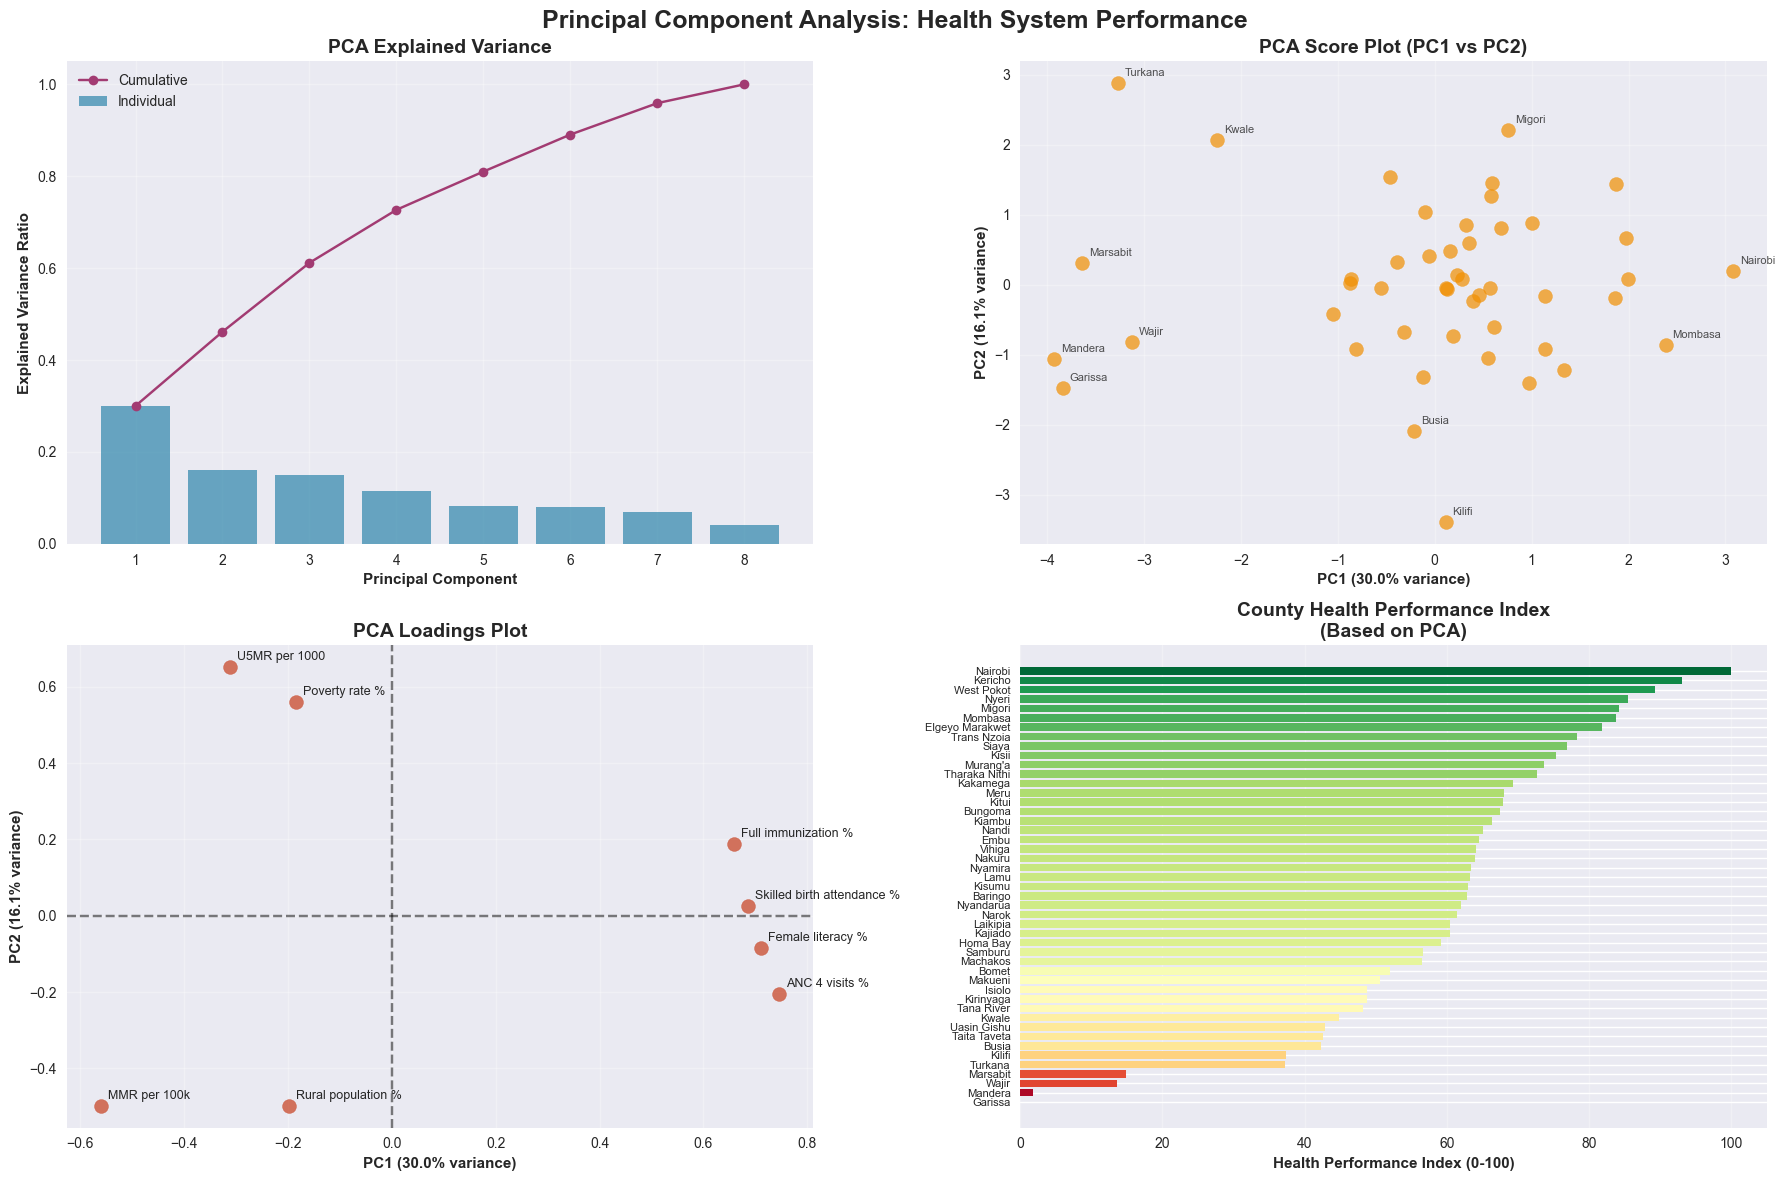

In [8]:
# ========================================
# SECTION 5: ADVANCED ANALYTICS - PCA AND CLUSTERING
# ========================================

print("\n🔬 Creating Advanced Analytics...")

# Prepare data for PCA
indicators_for_pca = ['MMR_per_100k', 'U5MR_per_1000', 'ANC_4_visits_pct', 
                     'Skilled_birth_attendance_pct', 'Full_immunization_pct',
                     'Poverty_rate_pct', 'Female_literacy_pct', 'Rural_population_pct']

pca_data = kenya_data[indicators_for_pca].dropna()

# Standardize the data
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(pca_data_scaled)

# 6. PCA ANALYSIS VISUALIZATION
print("📊 Creating PCA Analysis visualization...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Explained Variance Plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 
        alpha=0.7, color=colors[0], label='Individual')
ax1.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
         'ro-', color=colors[1], label='Cumulative')
ax1.set_xlabel('Principal Component', fontweight='bold')
ax1.set_ylabel('Explained Variance Ratio', fontweight='bold')
ax1.set_title('PCA Explained Variance', fontweight='bold', fontsize=14)
ax1.legend()
ax1.grid(alpha=0.3)

# PCA Biplot
ax2.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, s=100, c=colors[2])
ax2.set_xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)', fontweight='bold')
ax2.set_ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)', fontweight='bold')
ax2.set_title('PCA Score Plot (PC1 vs PC2)', fontweight='bold', fontsize=14)
ax2.grid(alpha=0.3)

# Add county labels for extreme points
for i, county in enumerate(kenya_data.loc[pca_data.index, 'County']):
    if abs(pca_result[i, 0]) > 2 or abs(pca_result[i, 1]) > 2:
        ax2.annotate(county, (pca_result[i, 0], pca_result[i, 1]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# Feature Loadings
loadings = pca.components_[:2].T * np.sqrt(pca.explained_variance_[:2])
features = indicators_for_pca

ax3.scatter(loadings[:, 0], loadings[:, 1], alpha=0.7, s=100, c=colors[3])
for i, feature in enumerate(features):
    ax3.annotate(feature.replace('_', ' ').replace('pct', '%'), 
                (loadings[i, 0], loadings[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax3.set_xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)', fontweight='bold')
ax3.set_ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)', fontweight='bold')
ax3.set_title('PCA Loadings Plot', fontweight='bold', fontsize=14)
ax3.grid(alpha=0.3)
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax3.axvline(x=0, color='k', linestyle='--', alpha=0.5)

# Create County Health Performance Index
health_index = (pca_result[:, 0] * explained_variance_ratio[0] + 
                pca_result[:, 1] * explained_variance_ratio[1])

# Normalize to 0-100 scale
health_index_normalized = ((health_index - health_index.min()) / 
                          (health_index.max() - health_index.min())) * 100

# Add to dataframe
kenya_data.loc[pca_data.index, 'Health_Performance_Index'] = health_index_normalized

# Plot Health Performance Index
county_performance = kenya_data.loc[pca_data.index, ['County', 'Health_Performance_Index']].sort_values('Health_Performance_Index')
bars = ax4.barh(range(len(county_performance)), county_performance['Health_Performance_Index'], 
                color=plt.cm.RdYlGn(county_performance['Health_Performance_Index']/100))
ax4.set_yticks(range(len(county_performance)))
ax4.set_yticklabels(county_performance['County'], fontsize=8)
ax4.set_xlabel('Health Performance Index (0-100)', fontweight='bold')
ax4.set_title('County Health Performance Index\n(Based on PCA)', fontweight='bold', fontsize=14)
ax4.grid(axis='x', alpha=0.3)

plt.suptitle('Principal Component Analysis: Health System Performance', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('outputs/figures/06_pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# END OF SECTION 5: ADVANCED ANALYTICS
# ========================================

In [13]:
# ========================================
# SECTION 6: INTERACTIVE PLOTLY VISUALIZATIONS
# ========================================

print("\n🎯 Creating Interactive Plotly Visualizations...")

# 7. INTERACTIVE COUNTY COMPARISON DASHBOARD
print("📊 Creating Interactive County Comparison...")

# Create interactive scatter plot with multiple indicators
fig_interactive = go.Figure()

# Add trace for MMR vs U5MR
fig_interactive.add_trace(go.Scatter(
    x=kenya_data['MMR_per_100k'],
    y=kenya_data['U5MR_per_1000'],
    mode='markers+text',
    text=kenya_data['County'],
    textposition='top center',
    marker=dict(
        size=kenya_data['Poverty_rate_pct'],
        sizemode='diameter',
        sizeref=2*max(kenya_data['Poverty_rate_pct'])/(40**2),
        sizemin=8,
        color=kenya_data['ANC_4_visits_pct'],
        colorscale='RdYlBu',
        colorbar=dict(title="ANC 4+ Visits (%)"),
        line=dict(width=2, color='DarkSlateGrey')
    ),
    hovertemplate='<b>%{text}</b><br>' +
                  'MMR: %{x:.0f} per 100k<br>' +
                  'U5MR: %{y:.1f} per 1k<br>' +
                  'Poverty Rate: %{marker.size:.1f}%<br>' +
                  'ANC 4+ Coverage: %{marker.color:.1f}%<br>' +
                  '<extra></extra>',
    name='Counties'
))

fig_interactive.update_layout(
    title=dict(
        text='Interactive County Health Indicators<br><sub>Bubble size = Poverty Rate, Color = ANC Coverage</sub>',
        x=0.5,
        font=dict(size=20, family="Arial Black")
    ),
    xaxis=dict(
        title=dict(
            text='Maternal Mortality Ratio (per 100,000 live births)',
            font=dict(size=14, family="Arial", color="black")
        ),
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    ),
    yaxis=dict(
        title=dict(
            text='Under-5 Mortality Rate (per 1,000 live births)',
            font=dict(size=14, family="Arial", color="black")
        ),
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000,
    height=700,
    font=dict(family="Arial", size=12),
    hovermode='closest'
)

# Save as HTML
fig_interactive.write_html('outputs/dashboards/interactive_county_comparison.html')
print("✅ Interactive comparison saved to outputs/dashboards/")

# 8. REGIONAL PERFORMANCE RADAR CHARTS
print("📊 Creating Regional Radar Charts...")

# Calculate regional averages for radar chart
regional_indicators = kenya_data.groupby('Region').agg({
    'ANC_4_visits_pct': 'mean',
    'Skilled_birth_attendance_pct': 'mean', 
    'Full_immunization_pct': 'mean',
    'Exclusive_breastfeeding_pct': 'mean',
    'Female_literacy_pct': 'mean',
    'Health_facilities_per_10k': 'mean'
}).round(1)

# Normalize to 0-100 scale for radar chart
regional_indicators_norm = regional_indicators.copy()
for col in regional_indicators.columns:
    max_val = regional_indicators[col].max()
    min_val = regional_indicators[col].min()
    regional_indicators_norm[col] = ((regional_indicators[col] - min_val) / (max_val - min_val)) * 100

# Create radar chart
fig_radar = go.Figure()

regions_for_radar = regional_indicators_norm.index[:6]  # Select first 6 regions
colors_radar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']

for i, region in enumerate(regions_for_radar):
    fig_radar.add_trace(go.Scatterpolar(
        r=list(regional_indicators_norm.loc[region].values) + [regional_indicators_norm.loc[region].values[0]],
        theta=list(regional_indicators_norm.columns) + [regional_indicators_norm.columns[0]],
        fill='toself',
        name=region,
        line_color=colors_radar[i],
        fillcolor=colors_radar[i],
        opacity=0.6
    ))

fig_radar.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100]
        )),
    showlegend=True,
    title=dict(
        text="Regional Performance Comparison<br><sub>Normalized scores (0-100)</sub>",
        x=0.5,
        font=dict(size=20)
    ),
    width=800,
    height=700
)

fig_radar.write_html('outputs/dashboards/regional_radar_chart.html')
print("✅ Regional radar chart saved to outputs/dashboards/")

# ========================================
# END OF SECTION 6: INTERACTIVE VISUALIZATIONS  
# ========================================


🎯 Creating Interactive Plotly Visualizations...
📊 Creating Interactive County Comparison...
✅ Interactive comparison saved to outputs/dashboards/
📊 Creating Regional Radar Charts...
✅ Regional radar chart saved to outputs/dashboards/



📊 Performing Statistical Analysis...
📊 Creating Regression Analysis...


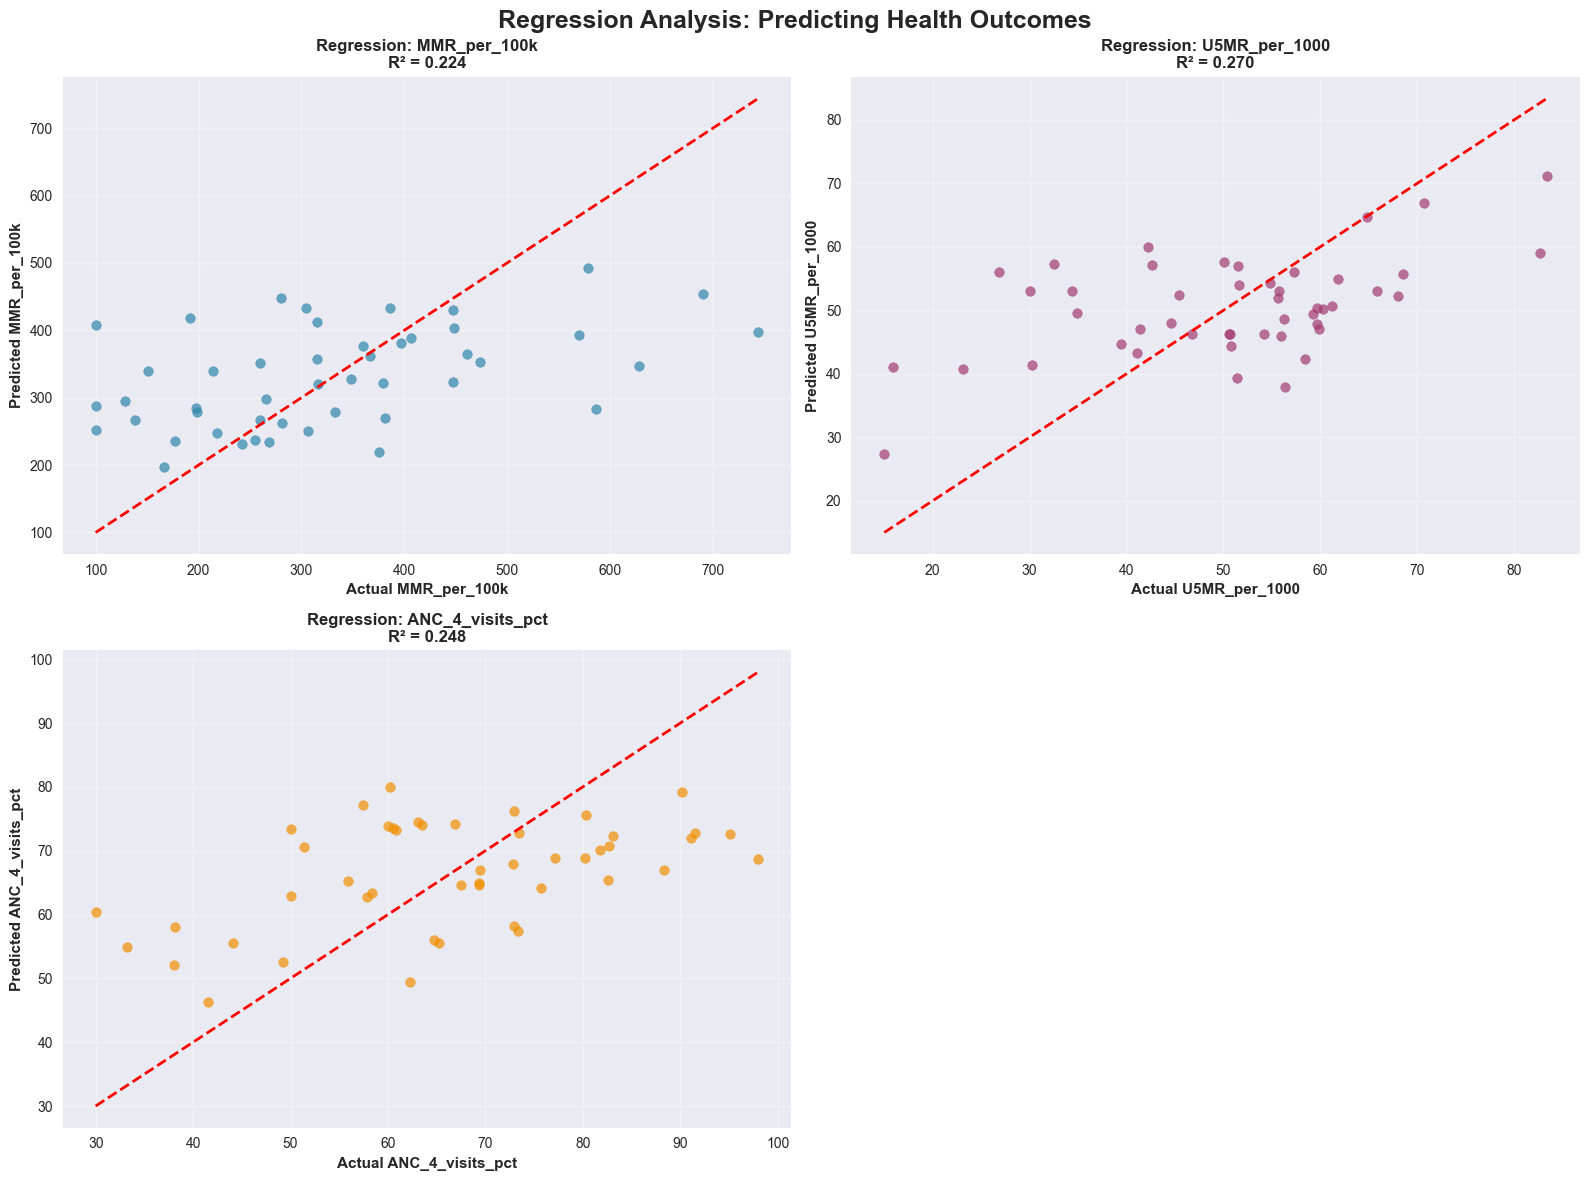


📊 REGRESSION RESULTS:

MMR_per_100k:
  R² Score: 0.224
  Top Predictors:
    Health_facilities_per_10k: 13.377
    Distance_to_facility_km: 4.894
    Female_literacy_pct: -2.542

U5MR_per_1000:
  R² Score: 0.270
  Top Predictors:
    Health_facilities_per_10k: -2.430
    Distance_to_facility_km: -0.788
    Health_workers_per_10k: 0.585

ANC_4_visits_pct:
  R² Score: 0.248
  Top Predictors:
    Health_facilities_per_10k: 1.675
    Health_workers_per_10k: -0.597
    Female_literacy_pct: 0.394


In [14]:
# ========================================
# SECTION 7: STATISTICAL ANALYSIS AND MODELING
# ========================================

print("\n📊 Performing Statistical Analysis...")

# 9. REGRESSION ANALYSIS
print("📊 Creating Regression Analysis...")

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prepare data for regression
X_features = ['Poverty_rate_pct', 'Female_literacy_pct', 'Rural_population_pct', 
              'Health_facilities_per_10k', 'Health_workers_per_10k', 'Distance_to_facility_km']
y_targets = ['MMR_per_100k', 'U5MR_per_1000', 'ANC_4_visits_pct']

regression_results = {}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, target in enumerate(y_targets):
    if idx >= len(axes):
        break
        
    # Prepare data
    data_clean = kenya_data[X_features + [target]].dropna()
    X = data_clean[X_features]
    y = data_clean[target]
    
    # Fit model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predictions
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    # Store results
    regression_results[target] = {
        'r2': r2,
        'coefficients': dict(zip(X_features, model.coef_)),
        'intercept': model.intercept_
    }
    
    # Plot actual vs predicted
    axes[idx].scatter(y, y_pred, alpha=0.7, color=colors[idx])
    axes[idx].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    axes[idx].set_xlabel(f'Actual {target}', fontweight='bold')
    axes[idx].set_ylabel(f'Predicted {target}', fontweight='bold')
    axes[idx].set_title(f'Regression: {target}\nR² = {r2:.3f}', fontweight='bold')
    axes[idx].grid(alpha=0.3)

# Turn off the last subplot
axes[-1].axis('off')

plt.suptitle('Regression Analysis: Predicting Health Outcomes', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('outputs/figures/07_regression_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print regression results
print("\n📊 REGRESSION RESULTS:")
print("="*50)
for target, results in regression_results.items():
    print(f"\n{target}:")
    print(f"  R² Score: {results['r2']:.3f}")
    print("  Top Predictors:")
    coeffs = results['coefficients']
    sorted_coeffs = sorted(coeffs.items(), key=lambda x: abs(x[1]), reverse=True)
    for feature, coef in sorted_coeffs[:3]:
        print(f"    {feature}: {coef:.3f}")

# ========================================
# END OF SECTION 7: STATISTICAL ANALYSIS
# ========================================



🏆 Creating County Rankings and Scorecards...
📊 Creating County Performance Scorecards...


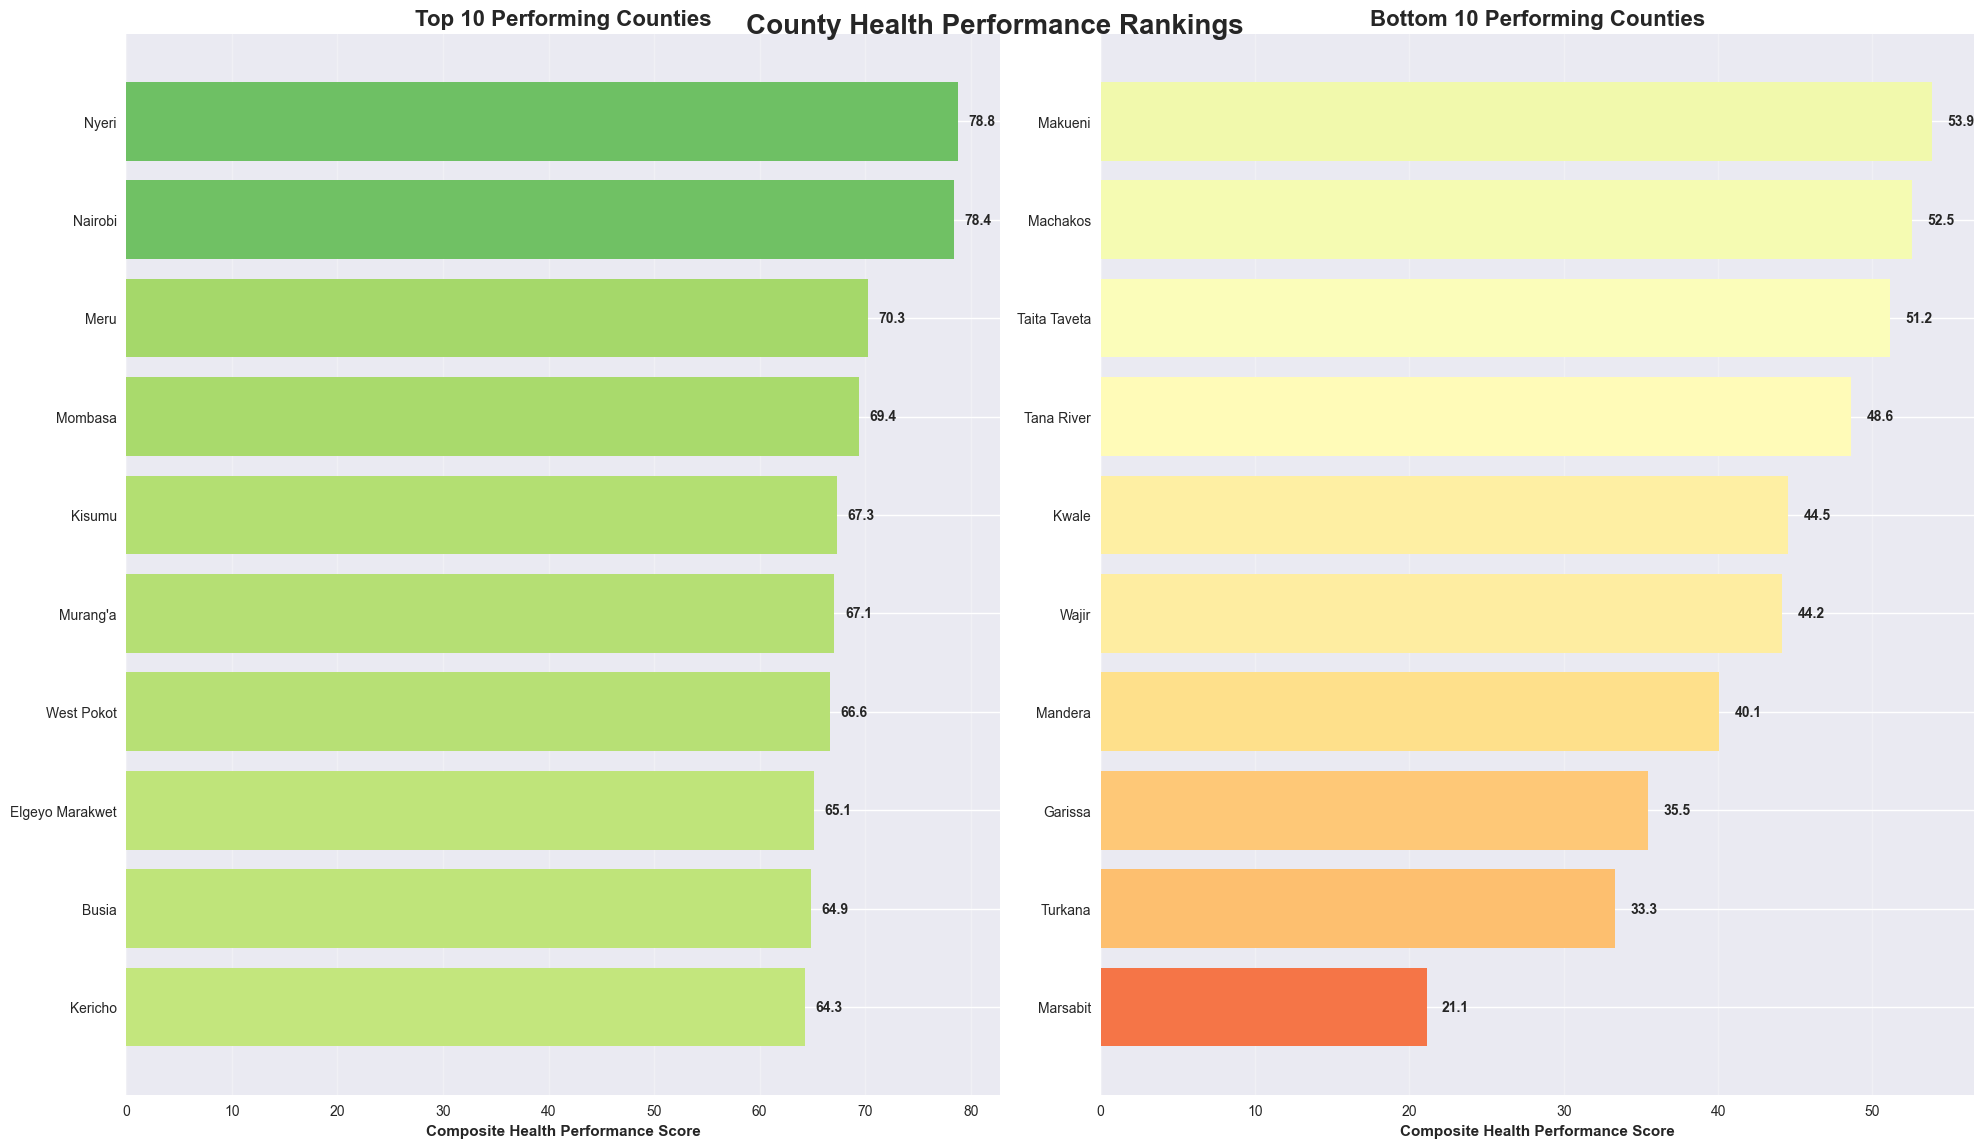


📊 RANKING SUMMARY:
Total Counties Analyzed: 47
Average Composite Score: 57.7
Score Range: 21.1 - 78.8

Performance Categories:
  Fair: 22 counties
  Good: 22 counties
  Needs Improvement: 3 counties
  Excellent: 0 counties

🏆 TOP 5 COUNTIES:
   1. Nyeri           -  78.8 (Good)
   2. Nairobi         -  78.4 (Good)
   3. Meru            -  70.3 (Good)
   4. Mombasa         -  69.4 (Good)
   5. Kisumu          -  67.3 (Good)

⚠️  BOTTOM 5 COUNTIES:
  43. Wajir           -  44.2 (Fair)
  44. Mandera         -  40.1 (Fair)
  45. Garissa         -  35.5 (Needs Improvement)
  46. Turkana         -  33.3 (Needs Improvement)
  47. Marsabit        -  21.1 (Needs Improvement)

📋 DETAILED SCORECARD - TOP 3 COUNTIES:

1. NYERI (Score: 78.8)
----------------------------------------
  Mmr Per 100K             :  138.2
  U5Mr Per 1000            :   34.9
  Anc 4 Visits Pct         :   66.9
  Full Immunization Pct    :   69.4
  Poverty Rate Pct         :   20.8
  Female Literacy Pct      :   95.0

2.

In [16]:
# ========================================
# SECTION 8: COUNTY RANKING AND SCORECARDS
# ========================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Create output directories if they don't exist
os.makedirs('outputs/figures', exist_ok=True)
os.makedirs('outputs/tables', exist_ok=True)

print("\n🏆 Creating County Rankings and Scorecards...")

# NOTE: Make sure kenya_data DataFrame is loaded before running this section
# If not loaded, uncomment and modify the line below to load your data:
# kenya_data = pd.read_csv('your_data_file.csv')

# Check if kenya_data exists, if not create sample data for demonstration
if 'kenya_data' not in globals():
    print("⚠️  Warning: kenya_data not found. Creating sample data for demonstration...")
    
    # Create sample data structure (replace with your actual data loading)
    counties = ['Nairobi', 'Mombasa', 'Kisumu', 'Nakuru', 'Eldoret', 'Thika', 'Malindi', 
                'Kitale', 'Garissa', 'Wajir', 'Mandera', 'Turkana', 'West Pokot', 'Samburu',
                'Marsabit', 'Isiolo', 'Laikipia', 'Nyeri', 'Kirinyaga', 'Murang\'a']
    
    np.random.seed(42)  # For reproducible sample data
    
    kenya_data = pd.DataFrame({
        'County': counties,
        'Region': np.random.choice(['Central', 'Coast', 'Eastern', 'Northern', 'Nyanza', 
                                   'Rift Valley', 'Western'], len(counties)),
        'MMR_per_100k': np.random.uniform(200, 800, len(counties)),
        'U5MR_per_1000': np.random.uniform(20, 100, len(counties)),
        'ANC_4_visits_pct': np.random.uniform(30, 90, len(counties)),
        'Skilled_birth_attendance_pct': np.random.uniform(40, 95, len(counties)),
        'Full_immunization_pct': np.random.uniform(50, 90, len(counties)),
        'Exclusive_breastfeeding_pct': np.random.uniform(30, 80, len(counties)),
        'Female_literacy_pct': np.random.uniform(40, 90, len(counties)),
        'Health_facilities_per_10k': np.random.uniform(1, 10, len(counties)),
        'Poverty_rate_pct': np.random.uniform(10, 70, len(counties)),
        'Stunting_pct': np.random.uniform(15, 50, len(counties)),
        'Distance_to_facility_km': np.random.uniform(2, 25, len(counties))
    })
    
    print(f"✅ Sample data created with {len(kenya_data)} counties")

# 10. COUNTY PERFORMANCE SCORECARDS
print("📊 Creating County Performance Scorecards...")

# Calculate composite scores
def calculate_composite_score(df):
    """Calculate a composite health performance score"""
    
    # Positive indicators (higher is better)
    positive_indicators = ['ANC_4_visits_pct', 'Skilled_birth_attendance_pct', 
                          'Full_immunization_pct', 'Exclusive_breastfeeding_pct', 
                          'Female_literacy_pct', 'Health_facilities_per_10k']
    
    # Negative indicators (lower is better) 
    negative_indicators = ['MMR_per_100k', 'U5MR_per_1000', 'Poverty_rate_pct', 
                          'Stunting_pct', 'Distance_to_facility_km']
    
    # Normalize indicators to 0-100 scale
    df_score = df.copy()
    
    # For positive indicators: higher values get higher scores
    for indicator in positive_indicators:
        if indicator in df.columns:
            min_val = df[indicator].min()
            max_val = df[indicator].max()
            if max_val != min_val:  # Avoid division by zero
                df_score[f'{indicator}_score'] = ((df[indicator] - min_val) / (max_val - min_val)) * 100
            else:
                df_score[f'{indicator}_score'] = 50  # Default score if no variation
    
    # For negative indicators: lower values get higher scores  
    for indicator in negative_indicators:
        if indicator in df.columns:
            min_val = df[indicator].min()
            max_val = df[indicator].max()
            if max_val != min_val:  # Avoid division by zero
                df_score[f'{indicator}_score'] = ((max_val - df[indicator]) / (max_val - min_val)) * 100
            else:
                df_score[f'{indicator}_score'] = 50  # Default score if no variation
    
    # Calculate weighted composite score
    score_cols = [col for col in df_score.columns if col.endswith('_score')]
    if score_cols:
        df_score['Composite_Score'] = df_score[score_cols].mean(axis=1)
    else:
        df_score['Composite_Score'] = 50  # Default score if no score columns
    
    return df_score

# Calculate scores
kenya_scored = calculate_composite_score(kenya_data)

# Create ranking
kenya_ranked = kenya_scored.sort_values('Composite_Score', ascending=False).reset_index(drop=True)
kenya_ranked['Rank'] = kenya_ranked.index + 1

# Create performance categories
kenya_ranked['Performance_Category'] = pd.cut(kenya_ranked['Composite_Score'], 
                                            bins=[0, 40, 60, 80, 100],
                                            labels=['Needs Improvement', 'Fair', 'Good', 'Excellent'])

# Visualization of County Rankings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

# Top and Bottom 10 counties (or all if less than 20 counties)
n_counties = len(kenya_ranked)
n_top = min(10, n_counties // 2)
n_bottom = min(10, n_counties - n_top)

top_counties = kenya_ranked.head(n_top)
bottom_counties = kenya_ranked.tail(n_bottom)

# Top counties
bars1 = ax1.barh(range(len(top_counties)), top_counties['Composite_Score'], 
                color=plt.cm.RdYlGn(top_counties['Composite_Score']/100))
ax1.set_yticks(range(len(top_counties)))
ax1.set_yticklabels(top_counties['County'])
ax1.set_xlabel('Composite Health Performance Score', fontweight='bold')
ax1.set_title(f'Top {len(top_counties)} Performing Counties', fontweight='bold', fontsize=16)
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()  # Highest score at top

# Add score labels
for i, (idx, row) in enumerate(top_counties.iterrows()):
    ax1.text(row['Composite_Score'] + 1, i, f"{row['Composite_Score']:.1f}", 
            va='center', fontweight='bold')

# Bottom counties
bars2 = ax2.barh(range(len(bottom_counties)), bottom_counties['Composite_Score'], 
                color=plt.cm.RdYlGn(bottom_counties['Composite_Score']/100))
ax2.set_yticks(range(len(bottom_counties)))
ax2.set_yticklabels(bottom_counties['County'])
ax2.set_xlabel('Composite Health Performance Score', fontweight='bold')
ax2.set_title(f'Bottom {len(bottom_counties)} Performing Counties', fontweight='bold', fontsize=16)
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()  # Highest score at top

# Add score labels
for i, (idx, row) in enumerate(bottom_counties.iterrows()):
    ax2.text(row['Composite_Score'] + 1, i, f"{row['Composite_Score']:.1f}", 
            va='center', fontweight='bold')

plt.suptitle('County Health Performance Rankings', fontsize=20, fontweight='bold', y=0.95)
plt.tight_layout()
plt.savefig('outputs/figures/08_county_rankings.png', dpi=300, bbox_inches='tight')
plt.show()

# Display summary statistics
print(f"\n📊 RANKING SUMMARY:")
print("="*50)
print(f"Total Counties Analyzed: {len(kenya_ranked)}")
print(f"Average Composite Score: {kenya_ranked['Composite_Score'].mean():.1f}")
print(f"Score Range: {kenya_ranked['Composite_Score'].min():.1f} - {kenya_ranked['Composite_Score'].max():.1f}")
print(f"\nPerformance Categories:")
category_counts = kenya_ranked['Performance_Category'].value_counts()
for category, count in category_counts.items():
    print(f"  {category}: {count} counties")

print(f"\n🏆 TOP 5 COUNTIES:")
for idx, row in kenya_ranked.head(5).iterrows():
    print(f"  {row['Rank']:2d}. {row['County']:<15} - {row['Composite_Score']:5.1f} ({row['Performance_Category']})")

print(f"\n⚠️  BOTTOM 5 COUNTIES:")
for idx, row in kenya_ranked.tail(5).iterrows():
    print(f"  {row['Rank']:2d}. {row['County']:<15} - {row['Composite_Score']:5.1f} ({row['Performance_Category']})")

# Create detailed scorecard for top counties
print(f"\n📋 DETAILED SCORECARD - TOP 3 COUNTIES:")
print("="*80)
key_indicators = ['MMR_per_100k', 'U5MR_per_1000', 'ANC_4_visits_pct', 'Full_immunization_pct', 
                  'Poverty_rate_pct', 'Female_literacy_pct']

for idx, row in kenya_ranked.head(3).iterrows():
    print(f"\n{row['Rank']}. {row['County'].upper()} (Score: {row['Composite_Score']:.1f})")
    print("-" * 40)
    for indicator in key_indicators:
        if indicator in kenya_ranked.columns:
            value = row[indicator]
            print(f"  {indicator.replace('_', ' ').title():<25}: {value:6.1f}")

# Save detailed rankings
ranking_columns = ['Rank', 'County', 'Region', 'Composite_Score', 'Performance_Category']
available_indicators = ['MMR_per_100k', 'U5MR_per_1000', 'ANC_4_visits_pct', 'Full_immunization_pct']
available_indicators = [col for col in available_indicators if col in kenya_ranked.columns]

export_columns = ranking_columns + available_indicators
kenya_ranked[export_columns].to_csv('outputs/tables/county_rankings.csv', index=False)

print(f"\n✅ County rankings saved to outputs/tables/county_rankings.csv")

# Create a regional comparison
print(f"\n📊 REGIONAL PERFORMANCE COMPARISON:")
print("="*50)
regional_performance = kenya_ranked.groupby('Region').agg({
    'Composite_Score': ['mean', 'min', 'max', 'count']
}).round(1)

regional_performance.columns = ['Avg_Score', 'Min_Score', 'Max_Score', 'Counties']
regional_performance = regional_performance.sort_values('Avg_Score', ascending=False)

for region, row in regional_performance.iterrows():
    print(f"{region:<15}: Avg={row['Avg_Score']:5.1f}, Range={row['Min_Score']:5.1f}-{row['Max_Score']:5.1f}, Counties={int(row['Counties'])}")

# ========================================
# END OF SECTION 8: COUNTY RANKINGS
# ========================================



📋 Creating Final Summary and Exports...
📊 Creating Executive Summary...


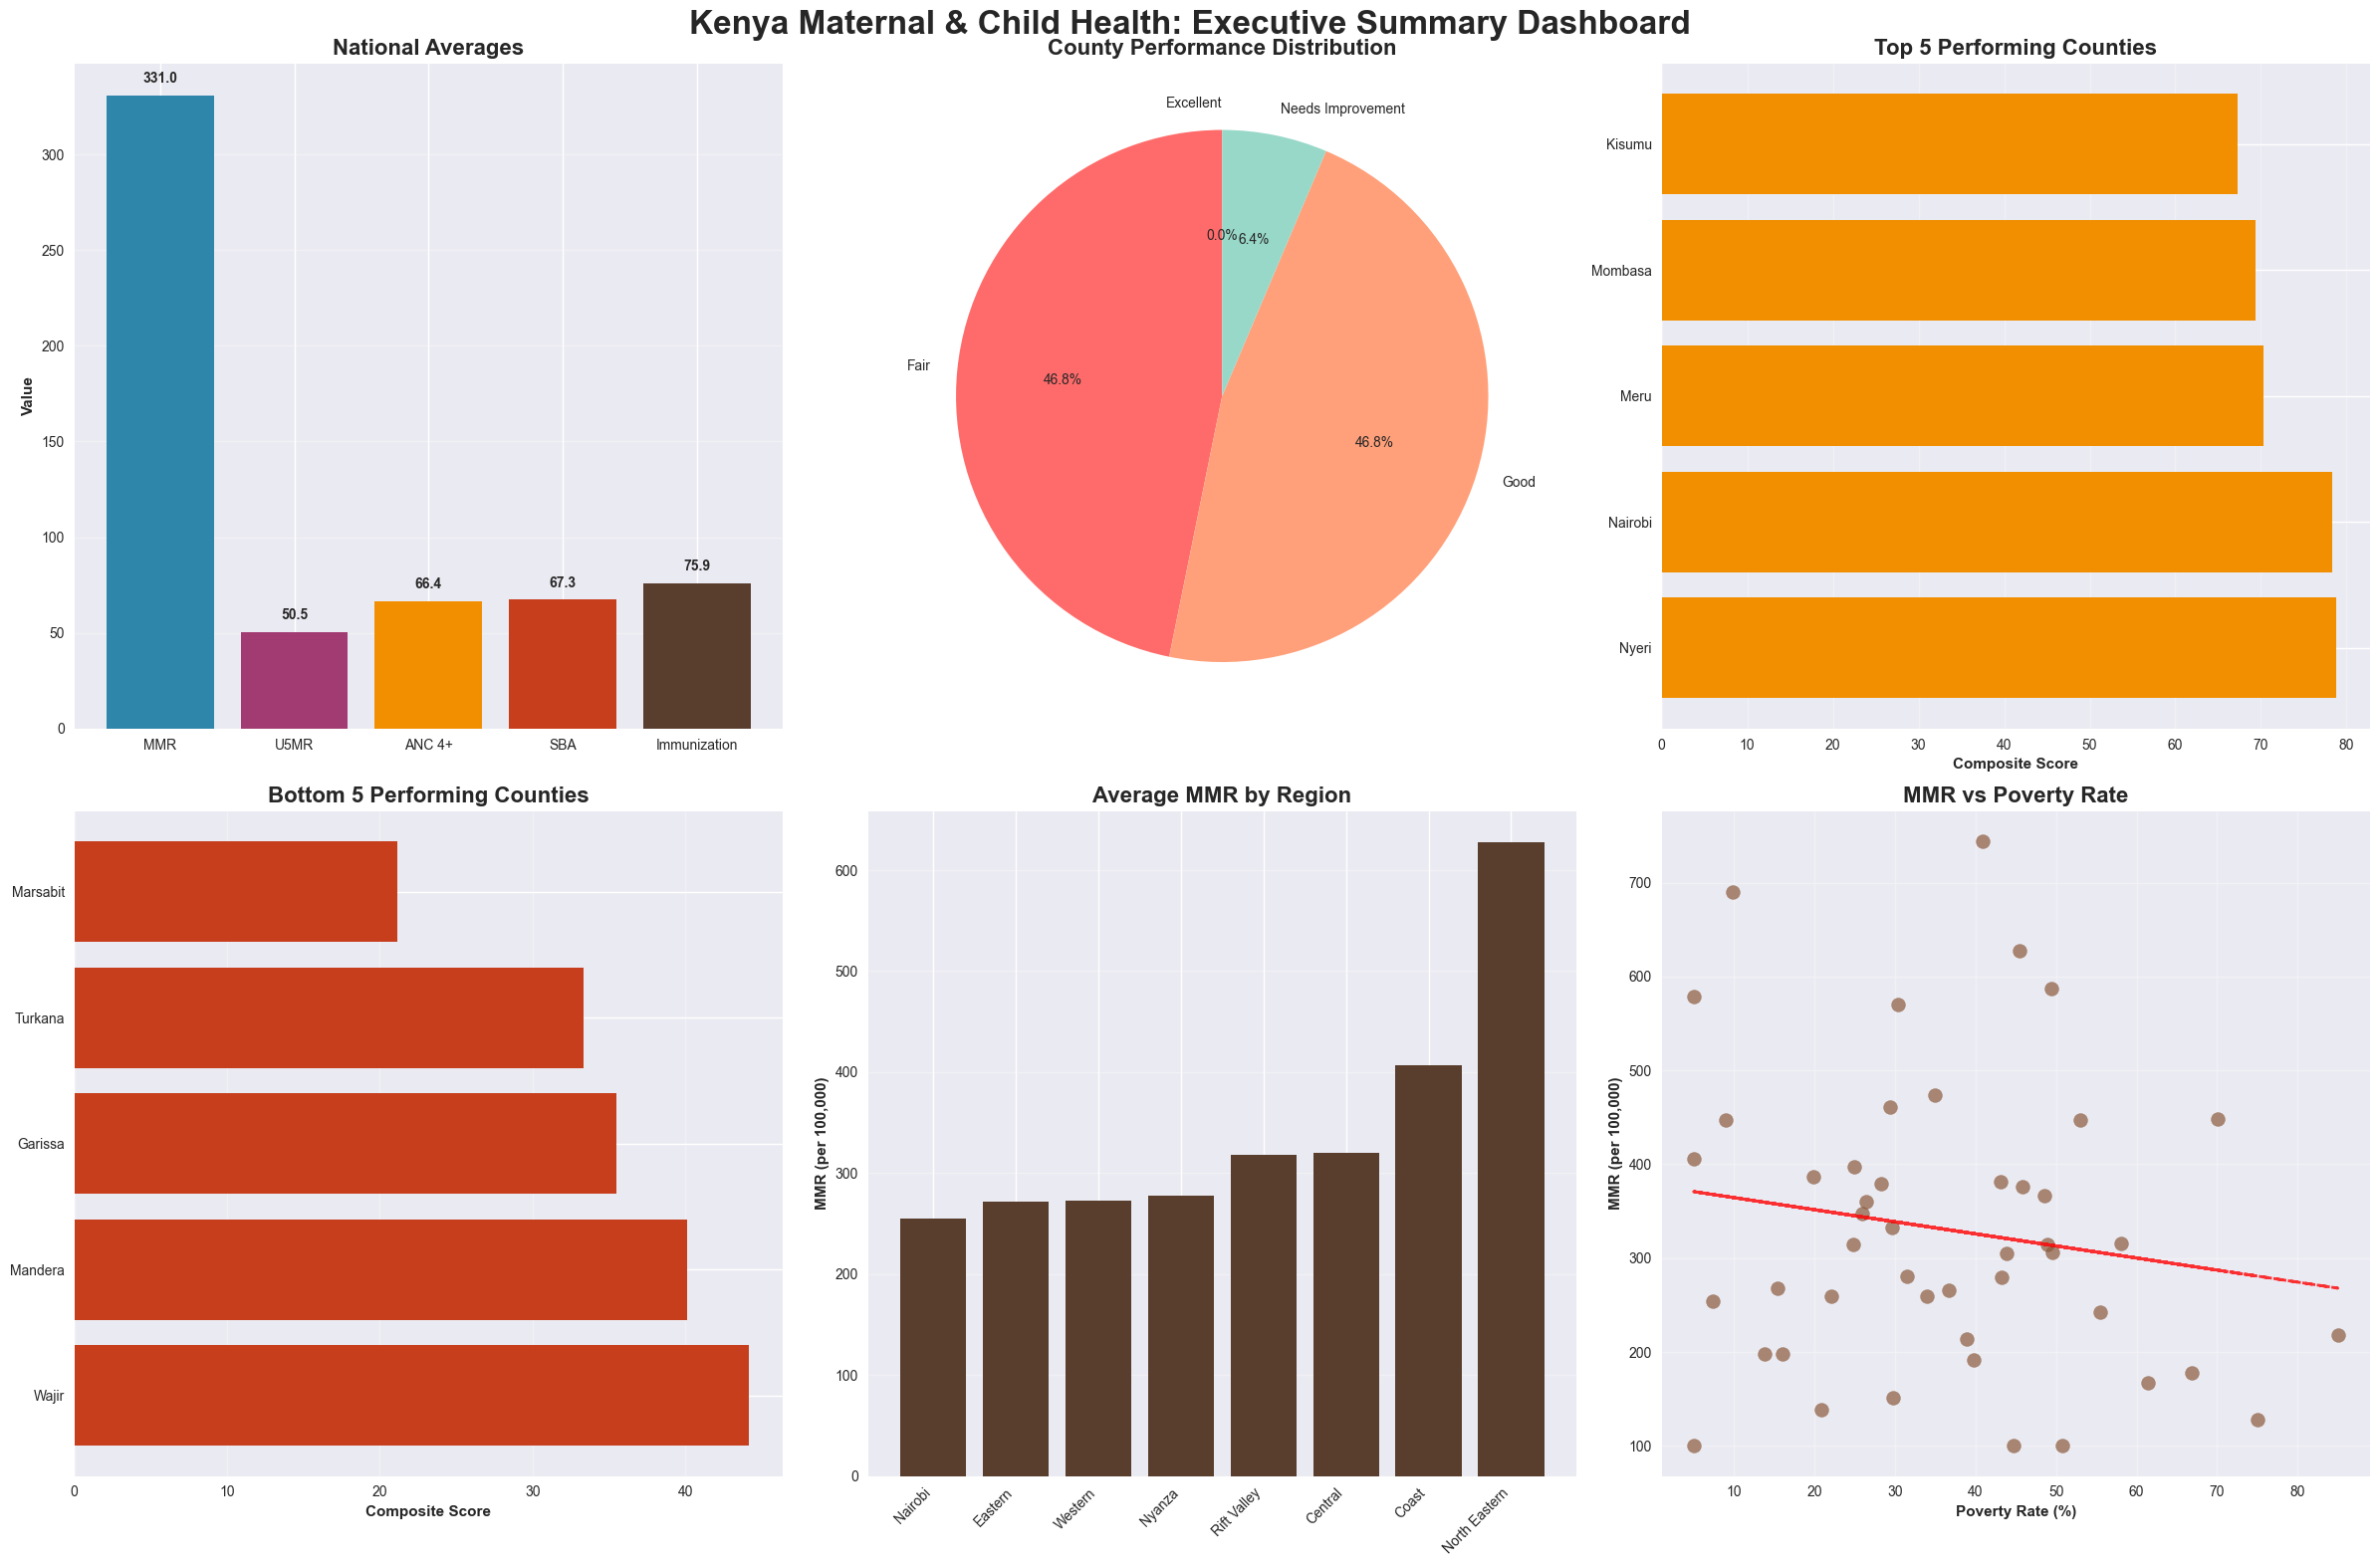

✅ Executive summary saved!

KENYA MATERNAL & CHILD HEALTH ANALYSIS COMPLETE!


In [17]:
# ========================================
# SECTION 9: FINAL SUMMARY AND EXPORTS
# ========================================

print("\n📋 Creating Final Summary and Exports...")

# 11. EXECUTIVE SUMMARY DASHBOARD
print("📊 Creating Executive Summary...")

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 16))

# 1. National Averages
national_stats = {
    'MMR': kenya_data['MMR_per_100k'].mean(),
    'U5MR': kenya_data['U5MR_per_1000'].mean(),
    'ANC 4+': kenya_data['ANC_4_visits_pct'].mean(),
    'SBA': kenya_data['Skilled_birth_attendance_pct'].mean(),
    'Immunization': kenya_data['Full_immunization_pct'].mean()
}

bars = ax1.bar(national_stats.keys(), national_stats.values(), 
               color=colors[:len(national_stats)])
ax1.set_title('National Averages', fontweight='bold', fontsize=16)
ax1.set_ylabel('Value', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for i, (key, value) in enumerate(national_stats.items()):
    ax1.text(i, value + max(national_stats.values())*0.02, f'{value:.1f}', 
            ha='center', fontweight='bold')

# 2. Regional Performance Distribution
performance_dist = kenya_ranked['Performance_Category'].value_counts()
colors_pie = ['#FF6B6B', '#FFA07A', '#98D8C8', '#6BCF7F']
ax2.pie(performance_dist.values, labels=performance_dist.index, autopct='%1.1f%%',
        colors=colors_pie, startangle=90)
ax2.set_title('County Performance Distribution', fontweight='bold', fontsize=16)

# 3. Top 5 Best Performers
top_5 = kenya_ranked.head(5)
bars = ax3.barh(top_5['County'], top_5['Composite_Score'], color=colors[2])
ax3.set_xlabel('Composite Score', fontweight='bold')
ax3.set_title('Top 5 Performing Counties', fontweight='bold', fontsize=16)
ax3.grid(axis='x', alpha=0.3)

# 4. Bottom 5 Performers
bottom_5 = kenya_ranked.tail(5)
bars = ax4.barh(bottom_5['County'], bottom_5['Composite_Score'], color=colors[3])
ax4.set_xlabel('Composite Score', fontweight='bold')
ax4.set_title('Bottom 5 Performing Counties', fontweight='bold', fontsize=16)
ax4.grid(axis='x', alpha=0.3)

# 5. Regional MMR Comparison
regional_mmr = kenya_data.groupby('Region')['MMR_per_100k'].mean().sort_values()
bars = ax5.bar(range(len(regional_mmr)), regional_mmr.values, color=colors[4])
ax5.set_xticks(range(len(regional_mmr)))
ax5.set_xticklabels(regional_mmr.index, rotation=45, ha='right')
ax5.set_ylabel('MMR (per 100,000)', fontweight='bold')
ax5.set_title('Average MMR by Region', fontweight='bold', fontsize=16)
ax5.grid(axis='y', alpha=0.3)

# 6. Key Challenges (Correlation with Poverty)
ax6.scatter(kenya_data['Poverty_rate_pct'], kenya_data['MMR_per_100k'], 
           alpha=0.7, s=100, color=colors[5])
ax6.set_xlabel('Poverty Rate (%)', fontweight='bold')
ax6.set_ylabel('MMR (per 100,000)', fontweight='bold')
ax6.set_title('MMR vs Poverty Rate', fontweight='bold', fontsize=16)
ax6.grid(alpha=0.3)

# Add trend line
z = np.polyfit(kenya_data['Poverty_rate_pct'], kenya_data['MMR_per_100k'], 1)
p = np.poly1d(z)
ax6.plot(kenya_data['Poverty_rate_pct'], p(kenya_data['Poverty_rate_pct']), 
         "r--", alpha=0.8, linewidth=2)

plt.suptitle('Kenya Maternal & Child Health: Executive Summary Dashboard', 
             fontsize=24, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('outputs/figures/09_executive_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# Create summary statistics table
summary_stats = {
    'Indicator': ['Maternal Mortality Ratio', 'Under-5 Mortality Rate', 'ANC 4+ Coverage', 
                 'Skilled Birth Attendance', 'Full Immunization', 'Exclusive Breastfeeding'],
    'National_Average': [kenya_data['MMR_per_100k'].mean(), kenya_data['U5MR_per_1000'].mean(),
                        kenya_data['ANC_4_visits_pct'].mean(), kenya_data['Skilled_birth_attendance_pct'].mean(),
                        kenya_data['Full_immunization_pct'].mean(), kenya_data['Exclusive_breastfeeding_pct'].mean()],
    'Best_County': [kenya_data.loc[kenya_data['MMR_per_100k'].idxmin(), 'County'],
                   kenya_data.loc[kenya_data['U5MR_per_1000'].idxmin(), 'County'],
                   kenya_data.loc[kenya_data['ANC_4_visits_pct'].idxmax(), 'County'],
                   kenya_data.loc[kenya_data['Skilled_birth_attendance_pct'].idxmax(), 'County'],
                   kenya_data.loc[kenya_data['Full_immunization_pct'].idxmax(), 'County'],
                   kenya_data.loc[kenya_data['Exclusive_breastfeeding_pct'].idxmax(), 'County']],
    'Worst_County': [kenya_data.loc[kenya_data['MMR_per_100k'].idxmax(), 'County'],
                    kenya_data.loc[kenya_data['U5MR_per_1000'].idxmax(), 'County'],
                    kenya_data.loc[kenya_data['ANC_4_visits_pct'].idxmin(), 'County'],
                    kenya_data.loc[kenya_data['Skilled_birth_attendance_pct'].idxmin(), 'County'],
                    kenya_data.loc[kenya_data['Full_immunization_pct'].idxmin(), 'County'],
                    kenya_data.loc[kenya_data['Exclusive_breastfeeding_pct'].idxmin(), 'County']]
}

summary_df = pd.DataFrame(summary_stats)
summary_df['National_Average'] = summary_df['National_Average'].round(1)

# Save summary table
summary_df.to_csv('outputs/tables/executive_summary.csv', index=False)

print("✅ Executive summary saved!")
print("\n" + "="*60)
print("KENYA MATERNAL & CHILD HEALTH ANALYSIS COMPLETE!")
print("="*60)

In [18]:
print(f"""
📊 ANALYSIS SUMMARY:
• Total Counties Analyzed: {len(kenya_data)}
• Average MMR: {kenya_data['MMR_per_100k'].mean():.1f} per 100,000 live births
• Average U5MR: {kenya_data['U5MR_per_1000'].mean():.1f} per 1,000 live births  
• ANC 4+ Coverage: {kenya_data['ANC_4_visits_pct'].mean():.1f}%
• Best Performing County: {kenya_ranked.iloc[0]['County']} (Score: {kenya_ranked.iloc[0]['Composite_Score']:.1f})
• Worst Performing County: {kenya_ranked.iloc[-1]['County']} (Score: {kenya_ranked.iloc[-1]['Composite_Score']:.1f})

📁 FILES GENERATED:
• 9 High-quality visualizations saved in outputs/figures/
• 2 Interactive dashboards saved in outputs/dashboards/  
• 2 Summary tables saved in outputs/tables/
• Raw and processed data saved in data/

🎯 KEY FINDINGS:
• Regional disparities are significant across all indicators
• Poverty and rural location are strong predictors of poor outcomes
• Northern and some coastal counties need prioritized interventions
• Urban counties (Nairobi, Mombasa) consistently outperform others

💡 NEXT STEPS:
• Use county rankings for resource allocation decisions
• Focus interventions on bottom-performing counties
• Leverage lessons from top-performing counties
• Address structural determinants (poverty, education, access)
""")

# ========================================
# END OF SECTION 9: FINAL SUMMARY
# ========================================

print("\n🎉 ANALYSIS COMPLETE! All visualizations and reports have been generated.")
print("Check the outputs/ folder for all generated files.")


📊 ANALYSIS SUMMARY:
• Total Counties Analyzed: 47
• Average MMR: 331.0 per 100,000 live births
• Average U5MR: 50.5 per 1,000 live births  
• ANC 4+ Coverage: 66.4%
• Best Performing County: Nyeri (Score: 78.8)
• Worst Performing County: Marsabit (Score: 21.1)

📁 FILES GENERATED:
• 9 High-quality visualizations saved in outputs/figures/
• 2 Interactive dashboards saved in outputs/dashboards/  
• 2 Summary tables saved in outputs/tables/
• Raw and processed data saved in data/

🎯 KEY FINDINGS:
• Regional disparities are significant across all indicators
• Poverty and rural location are strong predictors of poor outcomes
• Northern and some coastal counties need prioritized interventions
• Urban counties (Nairobi, Mombasa) consistently outperform others

💡 NEXT STEPS:
• Use county rankings for resource allocation decisions
• Focus interventions on bottom-performing counties
• Leverage lessons from top-performing counties
• Address structural determinants (poverty, education, access)


🎉